In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import seaborn as sns



## alle parts en items over de gehele tijd en alle linacs

In [230]:
linac2_headers = pd.read_csv("data/calblocks_update_table_cal_headers.csv", names=["date", "file_name", "empty", "thiing", "thing"])
linac2_items = pd.read_csv("data/calblocks_update_table_cal_items.csv",  names=["item", "category", "thing", "thiing"])
linac2_values = pd.read_csv("data/calblocks_update_table_cal_values.csv", names=["id", "calheaders_id", "item", "part", "value"])

linac2_headers.reset_index(inplace=True)
linac2_headers.set_index("level_0", inplace=True)
linac2_headers['datum'] = linac2_headers['date'].str.replace('/', '-', regex=False)

linac2_headers['date'] = pd.to_datetime(linac2_headers['date'], format='%d/%m/%Y')
linac2_headers["date"] = linac2_headers["date"].astype("str")

linac2_headers.columns = ["linac","date", "file_name", "empty", "thiing", "thing", "datum"]

BE5201 file: Low X-ray energy - 6 MV

In [231]:
tempdf = linac2_headers[["linac", "date", "file_name"]].merge(linac2_values[["calheaders_id", "item", "part", "value"]] ,left_on="level_0", right_on="calheaders_id", how="inner").drop(columns="calheaders_id")
merged_df = tempdf.merge(linac2_items[["item", "category"]], on = "item", how="inner")


merged_df = merged_df[merged_df["linac"] != 7460]

be5201 = merged_df[merged_df["file_name"] == "Be5201"]
be5201["Part&item"] = "I:"+ be5201["item"].astype(str) + " P:"+ be5201["part"].astype(str)

C:\Users\Laris\AppData\Local\Temp\ipykernel_9072\3422873399.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



geen part 45 en niet veranderende elementen

In [232]:
nop45 = be5201[be5201["part"] != 45]

for linac in list(set(nop45["linac"])):
    result = pd.DataFrame()

    linec_df = nop45[nop45["linac"] == linac]
    dates = list(set(linec_df["date"]))

    for item in range(len(dates)-1):
        old = linec_df[linec_df["date"] == dates[item]]
        new = linec_df[linec_df["date"] == dates[item+1]]

        diff = new["value"].values - old["value"].values
        temp = pd.DataFrame({
            "date": new["date"].tolist(),
            "difference": diff,
            "PI": new["Part&item"],
            "linac": new["linac"]
        })

        result = pd.concat([temp, result])
        

changed = result[result["difference"] != 0]

changes = changed["PI"].unique().tolist()

2983
2325
2638
2191


item                               44                                314  \
part                               141                               1     
category Monitored dose rate channel 1 Set dosimetry channel 1 reference   
count                            10.00                             10.00   
mean                            597.00                           1980.00   
std                               0.00                              6.32   
min                             597.00                           1978.00   
25%                             597.00                           1978.00   
50%                             597.00                           1978.00   
75%                             597.00                           1978.00   
max                             597.00                           1998.00   
count                            15.00                             15.00   
mean                            605.07                           2008.87   
std                               2.43                             22.65   
min                             600.00                           1927.00   
25%                             605.00                           2014.00   
50%                             605.00                           2015.00   
75%                             605.00                           2015.00   
max                             610.00                           2015.00   
count                             6.00                              6.00   
mean                            609.00                           1934.33   
std                               0.00                              5.89   
min                             609.00                           1927.00   
25%                             609.00                           1929.00   
50%                             609.00                           1937.00   
75%                             609.00                           1939.00   
max                             609.00                           1939.00   
count                            22.00                             22.00   
mean                            639.45                           2039.41   
std                              14.09                             14.57   
min                             628.00                           2014.00   
25%                             628.00                           2031.00   
50%                             628.00                           2039.00   
75%                             656.00                           2049.00   
max                             656.00                           2063.00   

item                                   315                           44   \
part                                   1                             134   
category Set dosimetry channel 2 reference Monitored dose rate channel 1   
count                                10.00                         10.00   
mean                               1721.20                        480.00   
std                                   6.96                          0.00   
min                                1719.00                        480.00   
25%                                1719.00                        480.00   
50%                                1719.00                        480.00   
75%                                1719.00                        480.00   
max                                1741.00                        480.00   
count                                15.00                         15.00   
mean                               1785.33                        410.60   
std                                  17.90                         11.96   
min                                1780.00                        403.00   
25%                                1780.50                        403.00   
50%                                1781.00                        403.00   
75%                                1781.00     

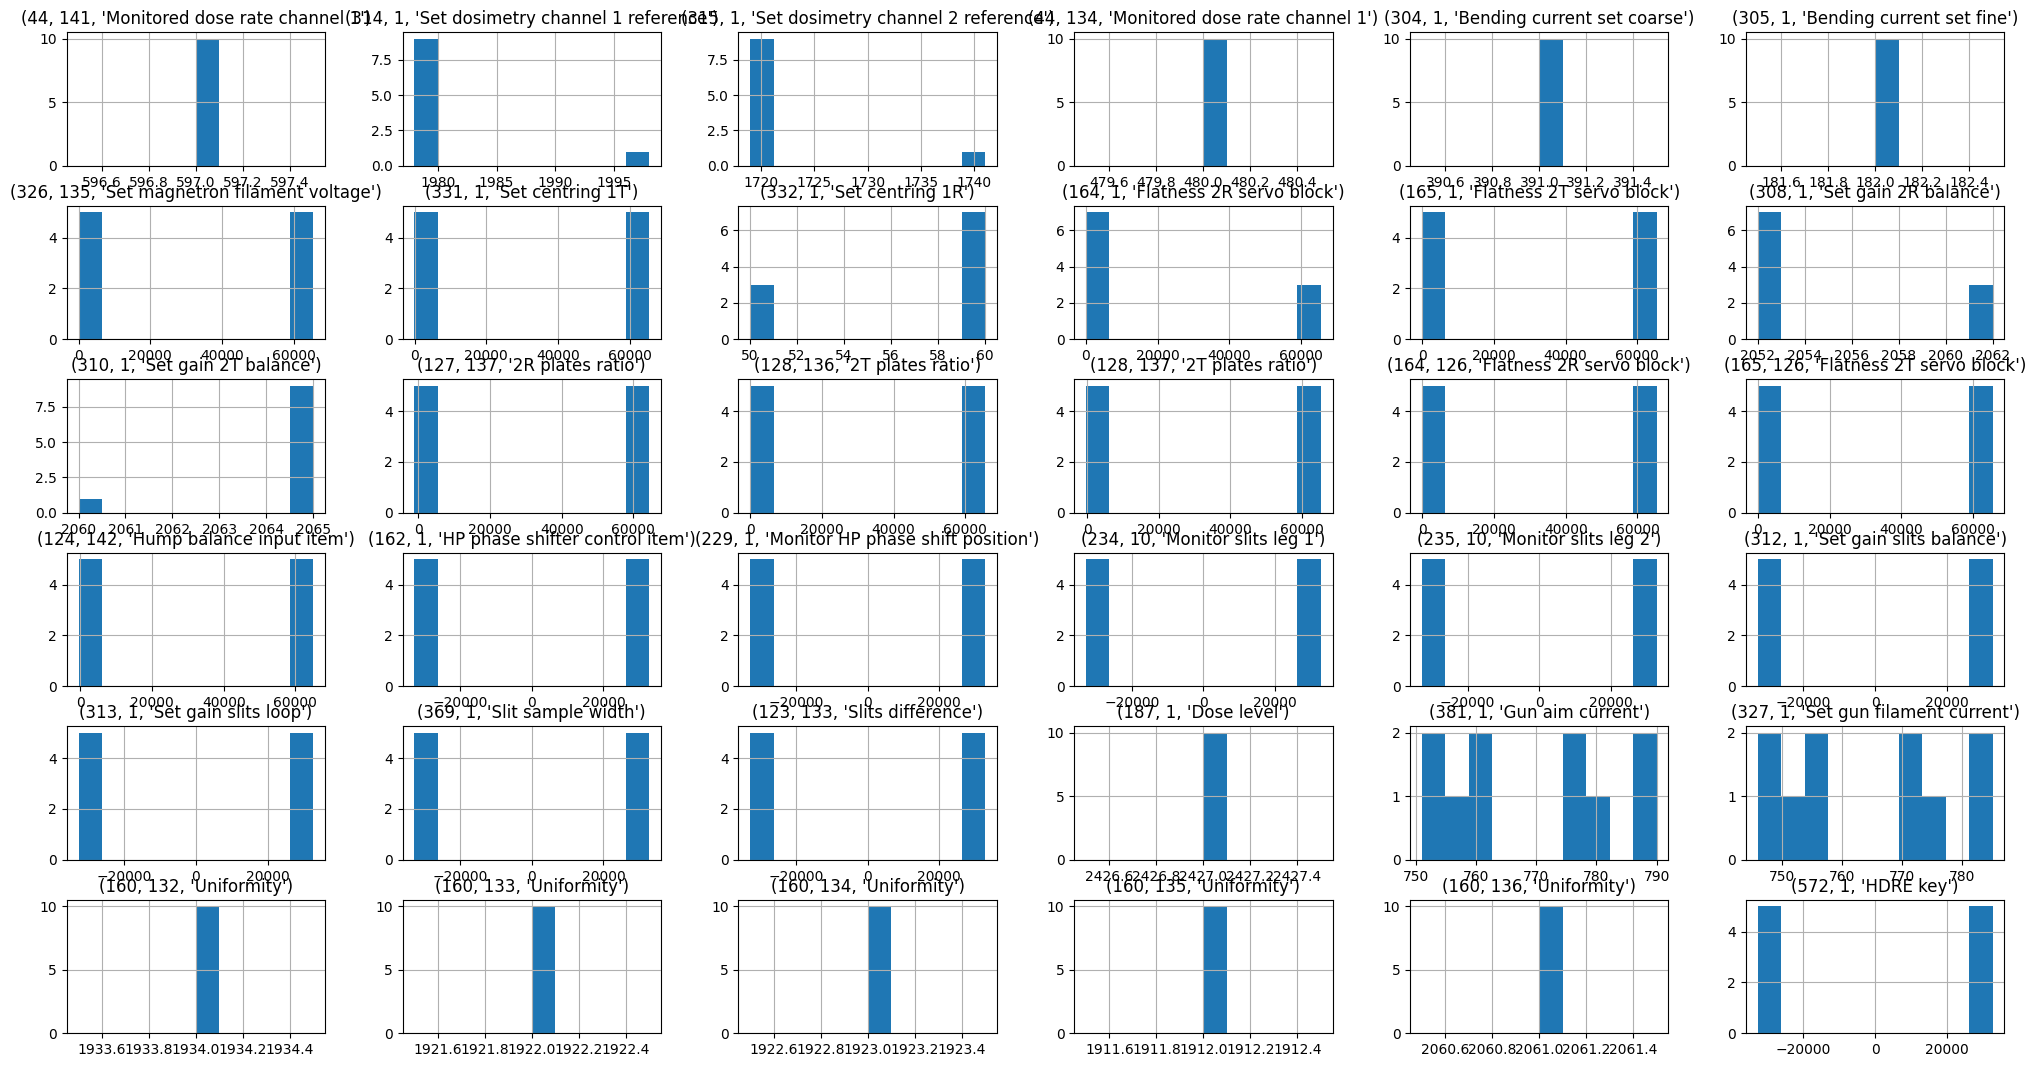

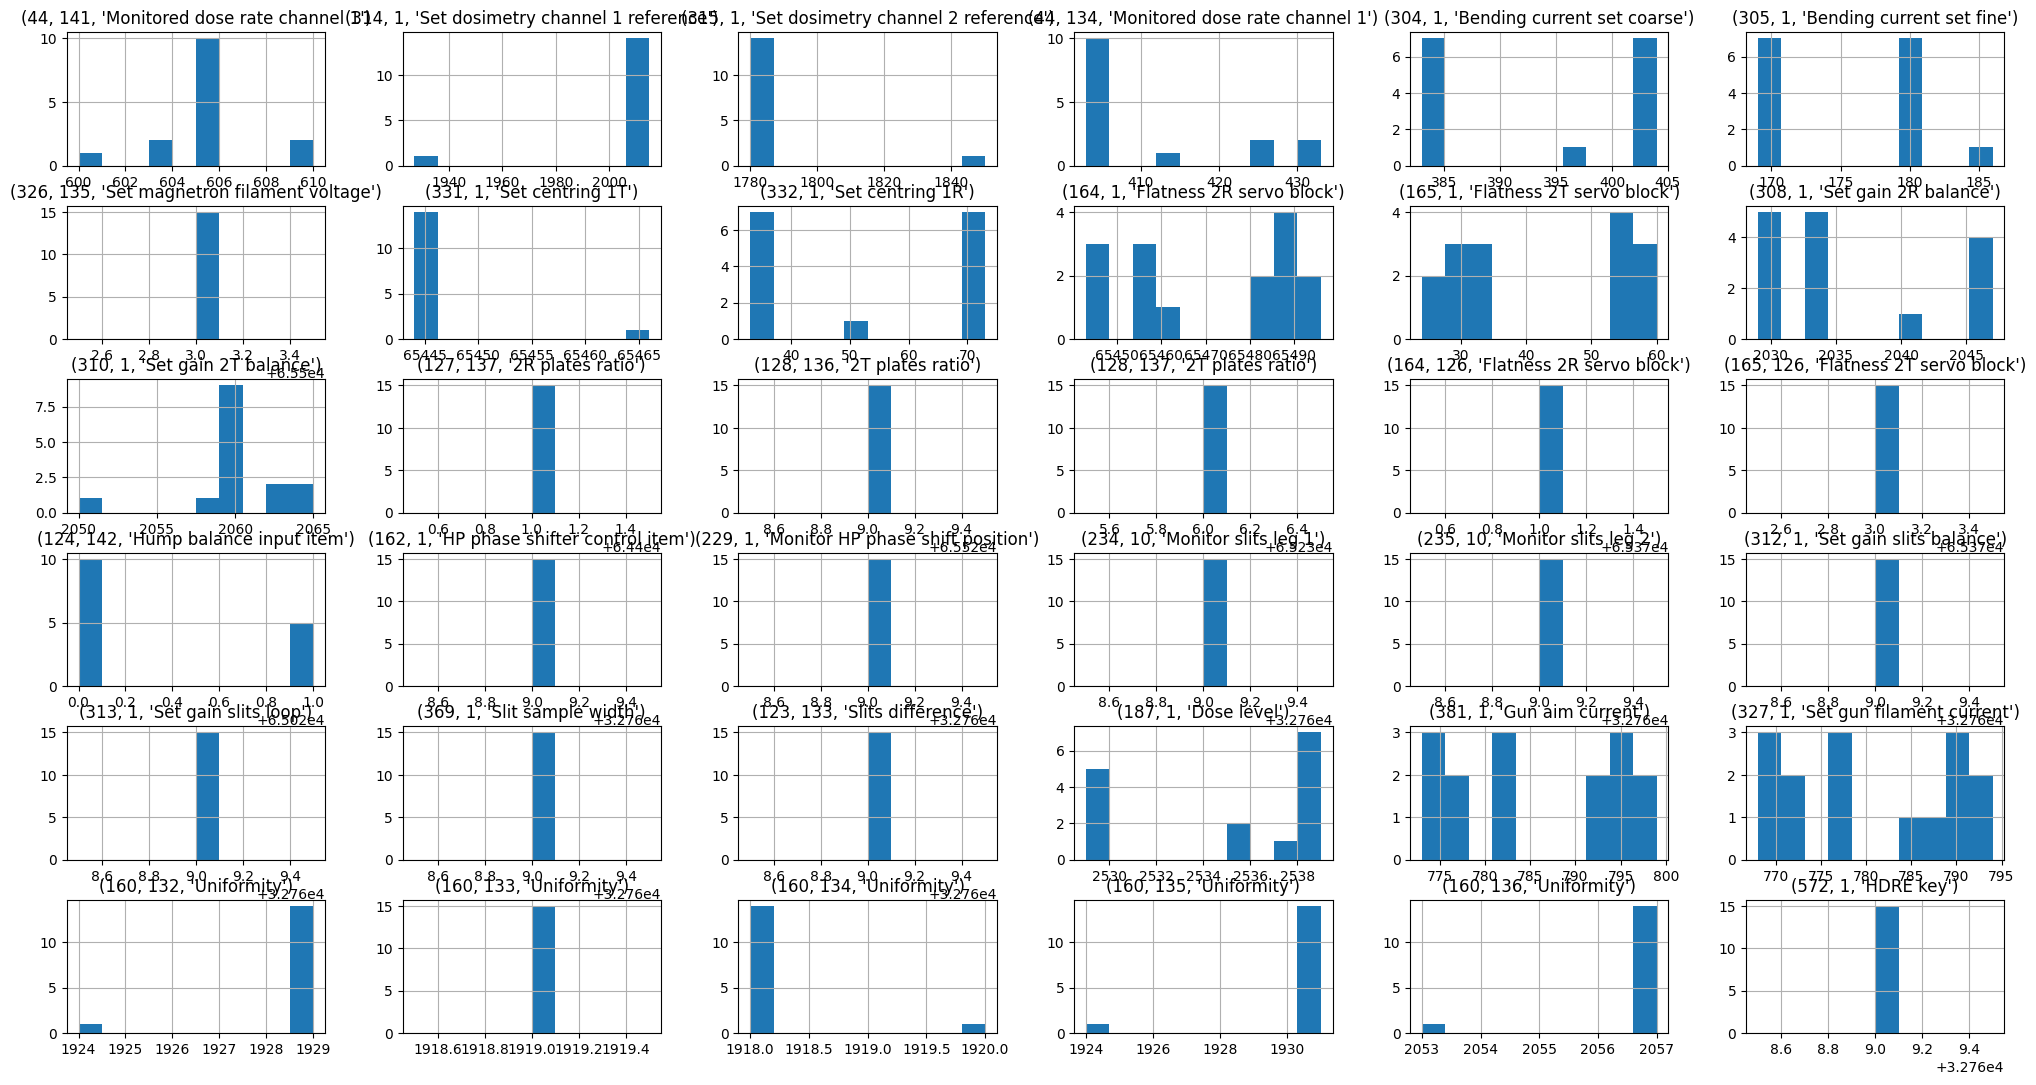

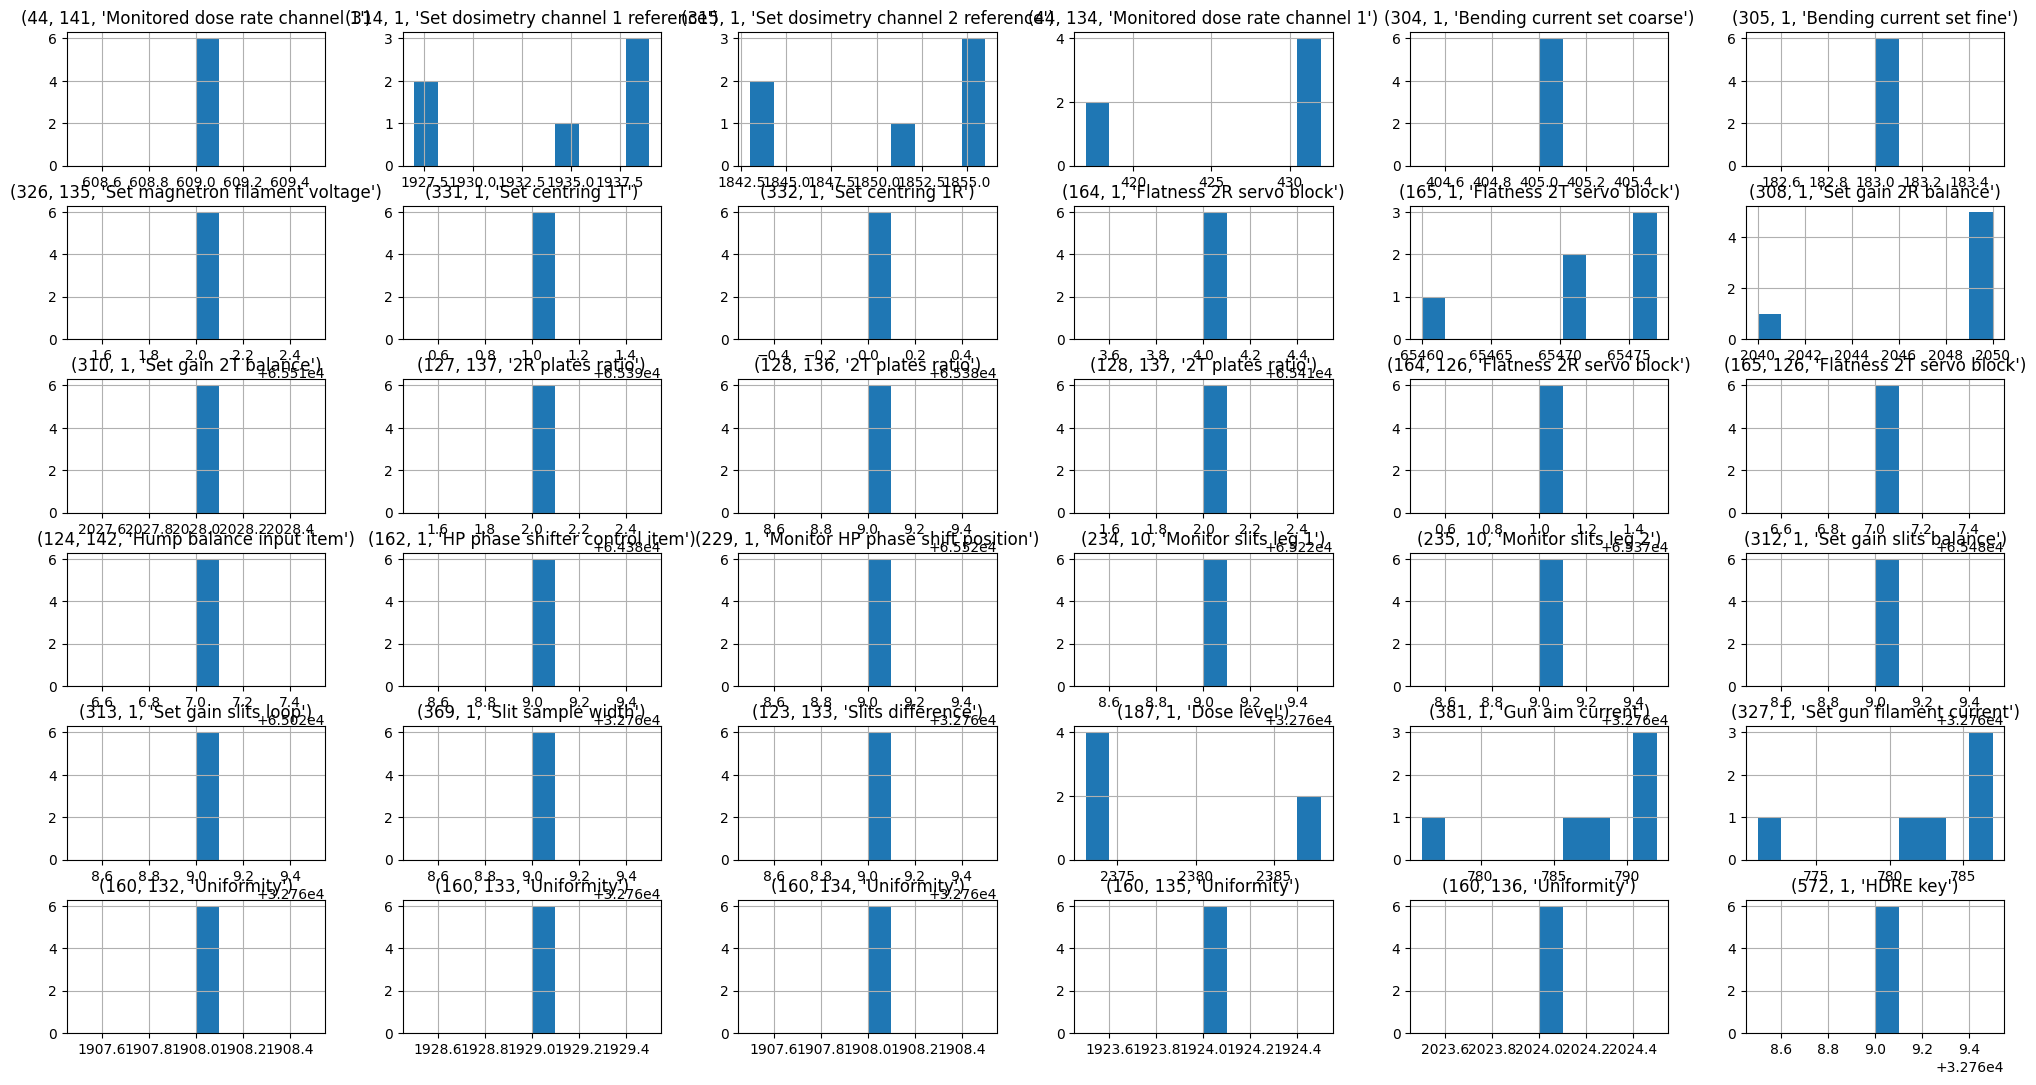

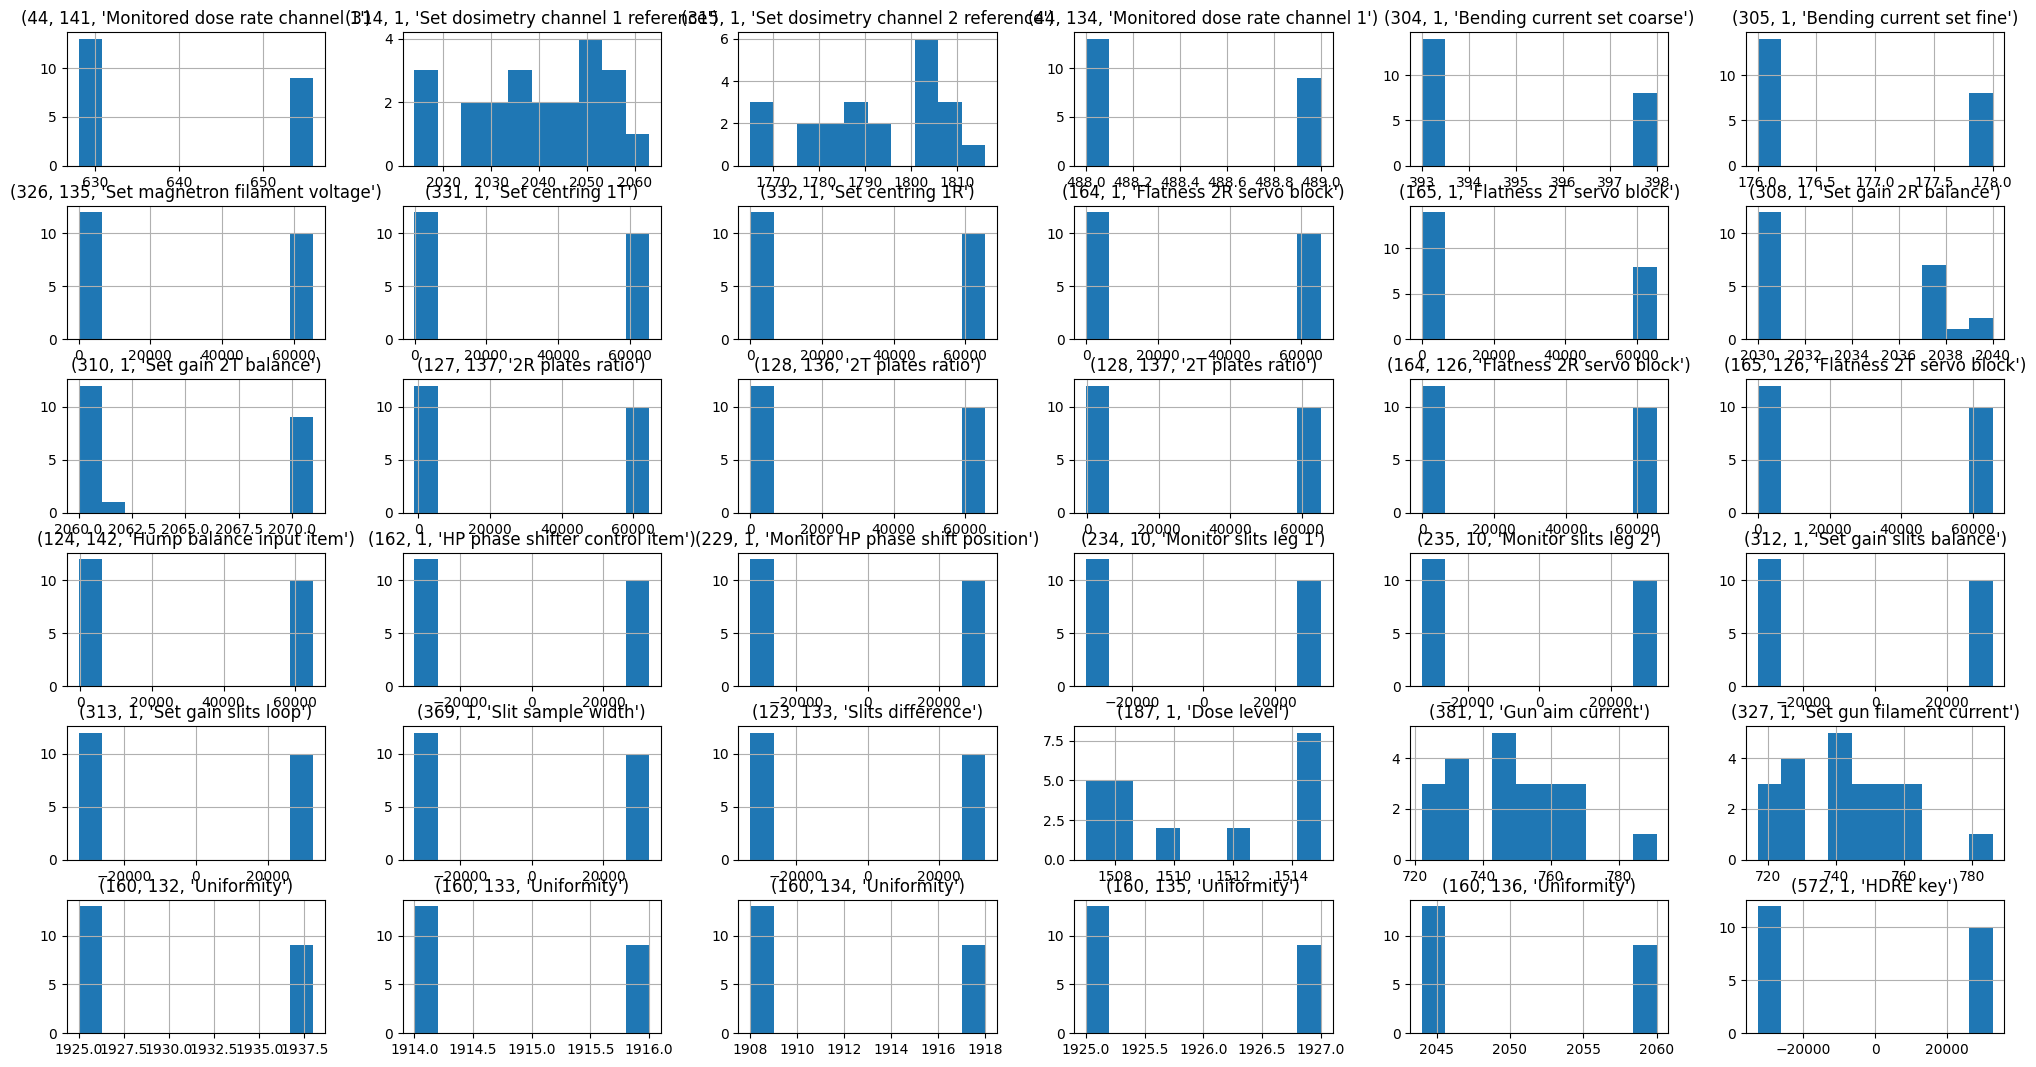

In [233]:
#only the changed combination of part and item
changes_df = be5201[be5201["Part&item"].isin(changes)]

show = pd.DataFrame()

# for every linac the describe of the same data
for linac in list(set(changes_df["linac"])):
    print(linac)
    pivoted = changes_df[changes_df["linac"] == linac].pivot(index="date", columns=["item", "part", "category"], values="value")
    describing = pivoted.describe()
    show = pd.concat([show, describing])
    pivoted.hist(figsize=(25,13));

    

show.round(2)

De meeste datapunten zijn geproduceerd bij linac 2191, dit kan het meest informatie bevatten. En is dus het meest interresant om op te focussen. De range van de data verschilt heel veel per part en item.

Ook veranderd niet elke part en item bij alle linacs, elke linac heeft uiteraard zijn eigen problemen. En bepaalde aanpassingen voor het goede energie niveau zijn dan nodig. Maar dat er een groot verschil kan zitten, zichtbaar in Flatness 2T servo block. Is best merkwaardig.

### Vergelijken BE bestanden


C:\Users\Laris\AppData\Local\Temp\ipykernel_9072\1089088569.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



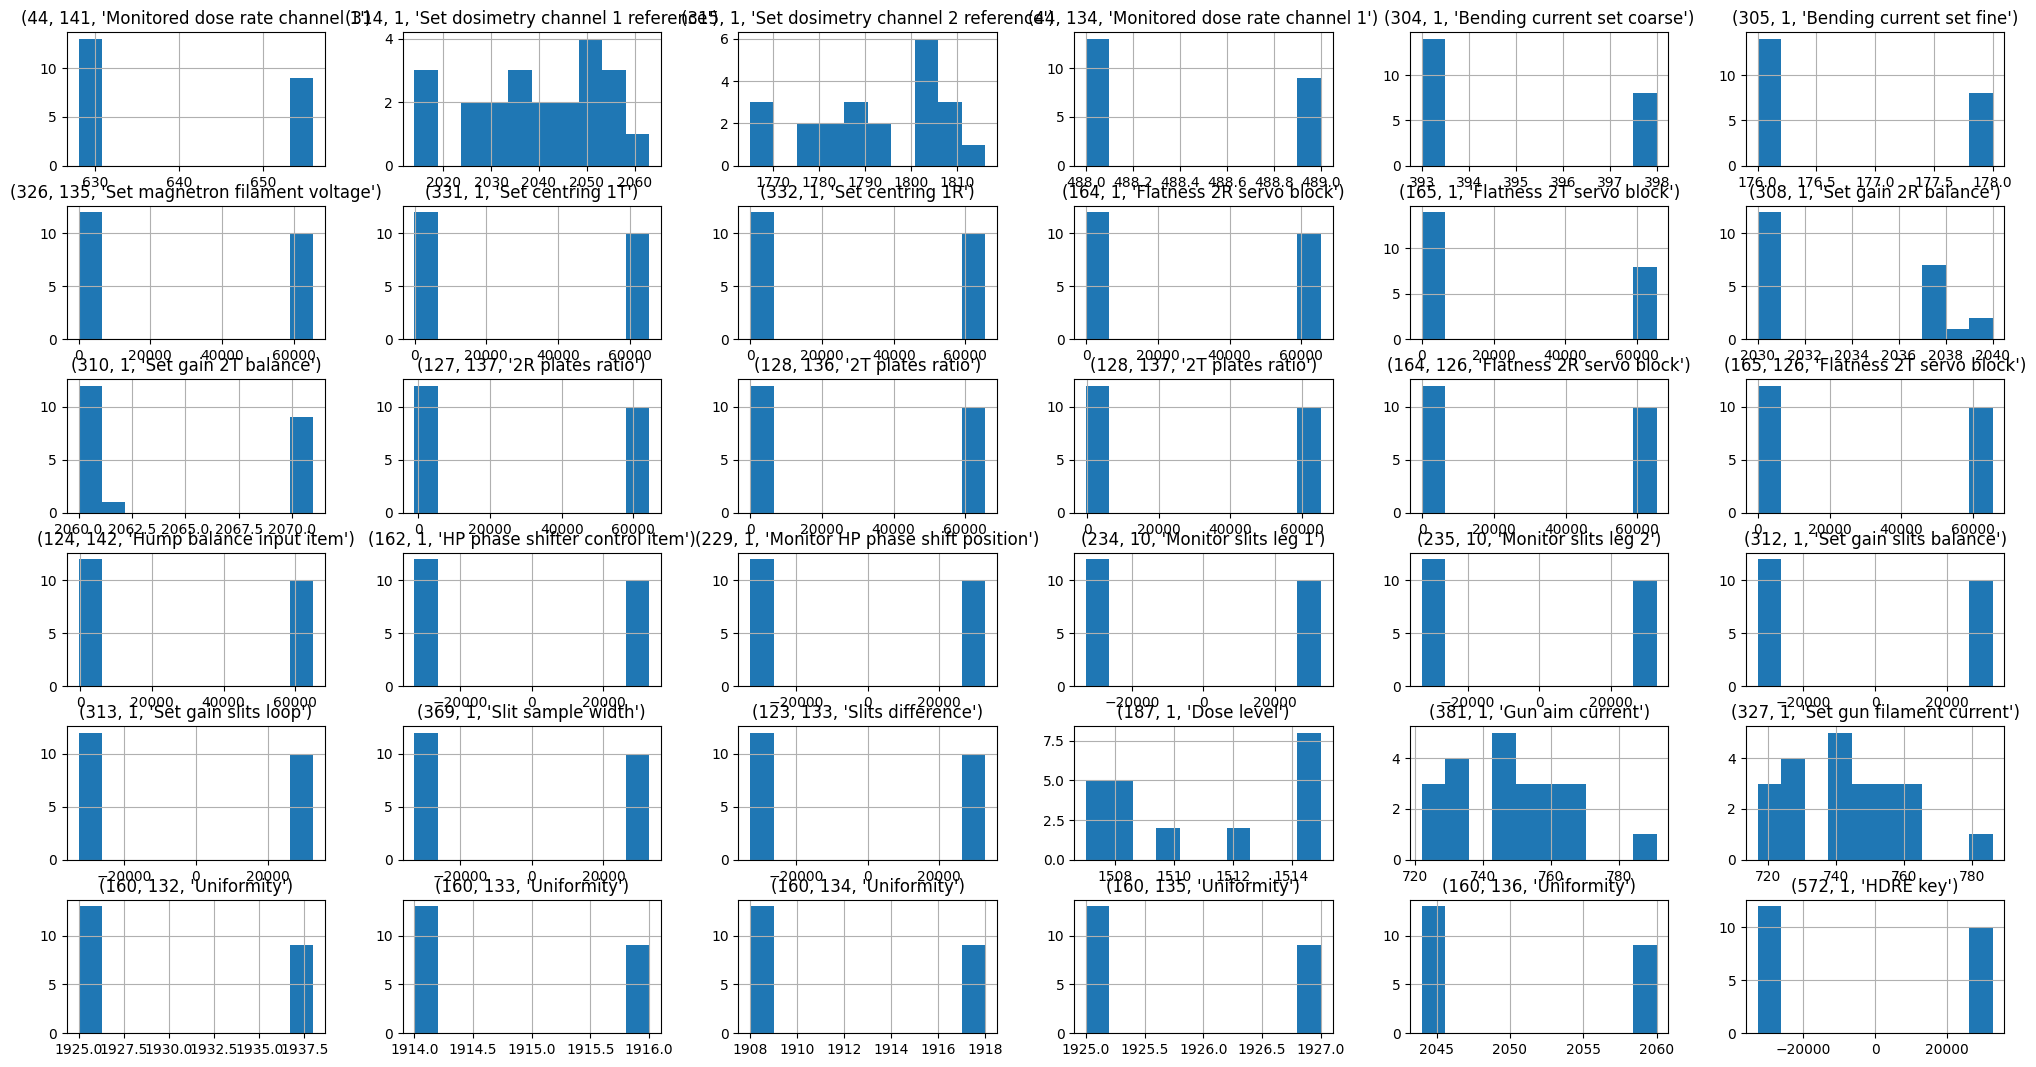

In [234]:
be5201 = merged_df[merged_df["file_name"] == "Be5201"]
be5201["Part&item"] = "I:"+ be5201["item"].astype(str) + " P:"+ be5201["part"].astype(str)

changes_df = be5201[be5201["Part&item"].isin(changes)]


pivoted = changes_df[changes_df["linac"] == 2191].pivot(index="date", columns=["item", "part", "category"], values="value")

pivoted.hist(figsize=(25,13));

C:\Users\Laris\AppData\Local\Temp\ipykernel_9072\663203575.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



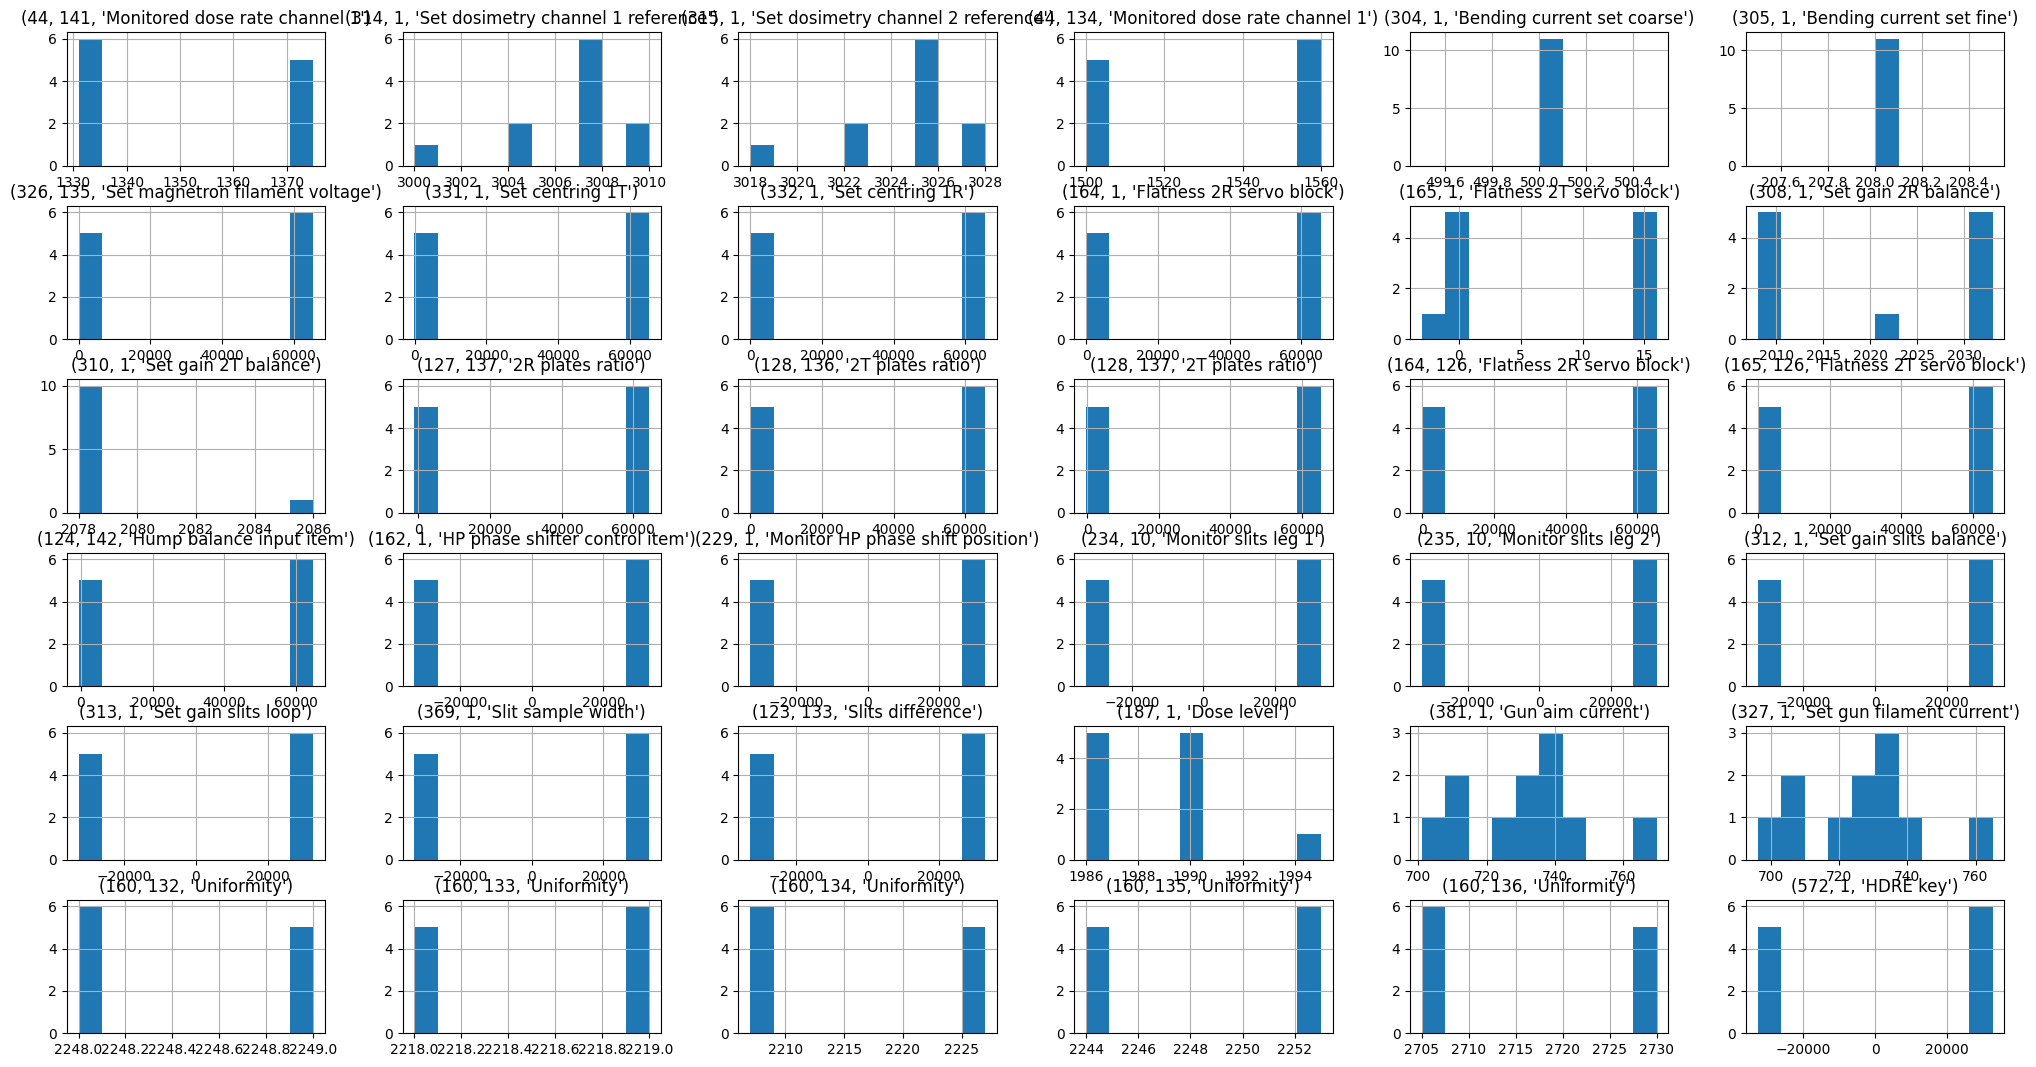

In [235]:
be5205 = merged_df[merged_df["file_name"] == "Be5205"]
be5205["Part&item"] = "I:"+ be5205["item"].astype(str) + " P:"+ be5205["part"].astype(str)

changes_df = be5205[be5205["Part&item"].isin(changes)]


pivoted_05 = changes_df[changes_df["linac"] == 2191].pivot(index=["date","linac"], columns=["item", "part", "category"], values="value")

pivoted_05.hist(figsize=(25,13));

Bij een ander energie niveau, zijn niet de zelfde verandering in de items aanwezig. Zelfs de zelfde items worden niet veranderd. Meerdere items, zijn 1x veranderd, of zijn in deze linac niet veranderd. Ook zijn er geen standaard verdeling aanwezig.

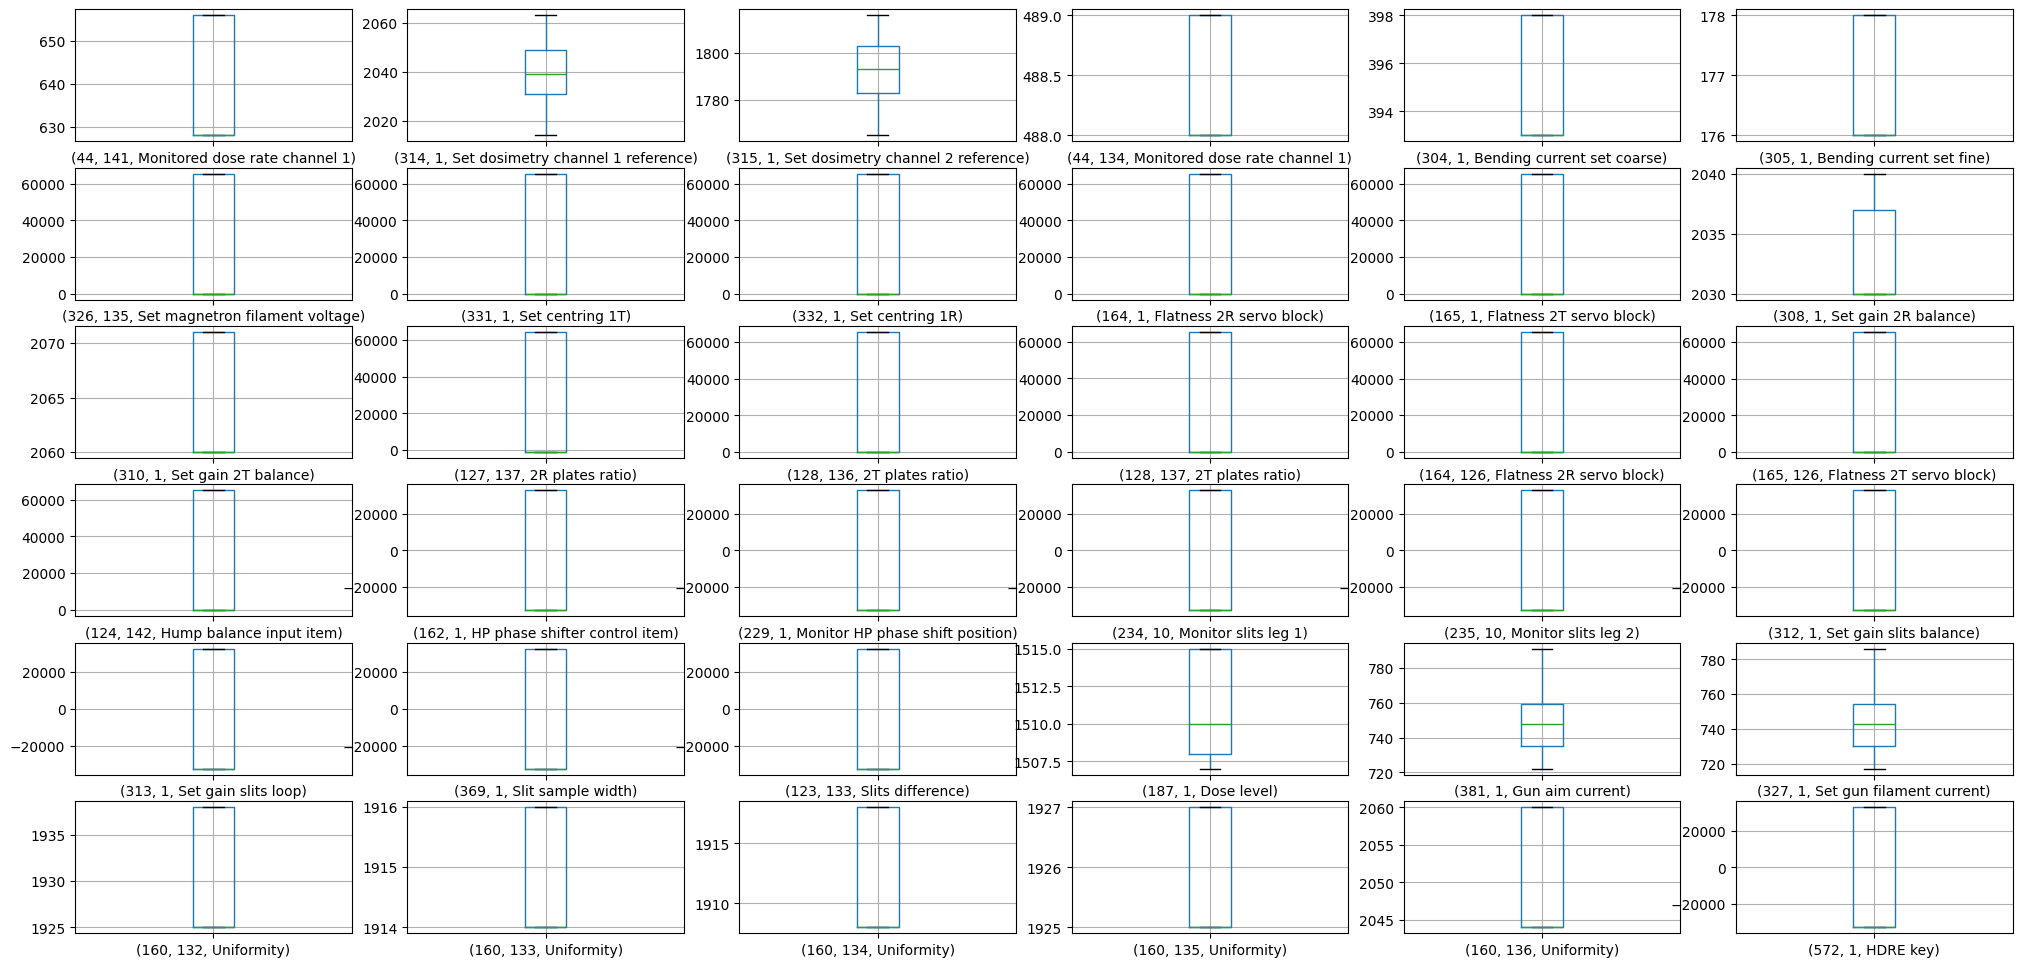

In [236]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(25, 12));
for num in range(len(pivoted.columns)):
    row, col = divmod(num, 6)
    pivoted.iloc[:, num: num+1].boxplot(ax=axes[row, col])

Door de kleine dataset zijn er niet veel outliers aanwezig. Alleen bij item 314 en 315 is een outlier aanwezig.

In [237]:

linac3_01 = be5201[be5201["linac"] == 2191].sort_values(by="date")


px.line(linac3_01[linac3_01["item"].isin([314, 315])], x="date", y ="value", color="item" , hover_data="date", markers=True)

Als de outlier dichterbij wordt bekeken, is dit de meest recente punt van maart 12 2025. Deze items wordden geffecteerd door de druk en temperatuur. 

In [238]:
# Filter relevant data
changes_df = be5201[be5201["Part&item"].isin(changes)]


# Pivot the dataframe
pivoted = changes_df.pivot(index=["date", "linac"], columns=["item", "part", "category"], values="value").reset_index()

# Flatten column names
pivoted.columns = [
    '_'.join(map(str, col)).strip() if isinstance(col, tuple) else col
    for col in pivoted.columns
]

# Rename the incorrectly flattened date/linac columns
pivoted = pivoted.rename(columns={"date__": "date", "linac__": "linac"})

# Select value columns for plotting
value_cols = [col for col in pivoted.columns if col not in ['date', 'linac']]

# Plot with seaborn
sns.pairplot(pivoted, hue="linac", vars=value_cols, plot_kws={'alpha': 0.1});


Hier is nu ook heel goed zichtbaar dat niet alle elementen bij elke linac veranderd worden. Er zijn geen directe clusters te herkennen of dat waarden in bepaalde ranges blijft. Dit is afhankelijk per linac. Hierdoor moet een model getrained worden per linac.

Deze onderstaande lijnen zijn meerdere veranderingen ondergaan

In [239]:
df_2191 = changes_df[changes_df["linac"] == 2191]

px.line(df_2191[df_2191["category"].isin(["Set dosimetry channel 1 reference", "Set dosimetry channel d reference",
                               "Gun aim current", "Dose level", "Set gun filament current"])], x="date", y="value", color="Part&item")

## Item 187, Dose level

In [240]:

be5201 = be5201.sort_values(by=['date', 'linac'])

px.line(be5201[be5201["item"] == 187], x="date", y ="value", color="linac", hover_data="category", markers=True)

### Outliers

In [241]:
def det_outliers(all):
    total = pd.DataFrame()
    for linac in all["linac"].unique():
        df = all[all["linac"] == linac].copy()  

        # Calculate Moving Averages
        df['SMA'] = df["value"].rolling(window=3).mean()

        # Calculate residuals (deviation from SMA)
        df['residual'] = df['value'] - df['SMA']

        # Rolling standard deviation of residuals
        df['rolling_std'] = df['residual'].rolling(window=6).std()

        # Identify outliers using a threshold (k = 2)
        k = 2
        df['is_outlier'] = np.abs(df['residual']) > (k * df['rolling_std'])

        # Collect outliers
        outliers = df[df['is_outlier']]
        total = pd.concat([total, outliers])
        
    return total


In [242]:
outliers = det_outliers(be5201[be5201["item"] == 187])

fig = px.line(be5201[be5201["item"] == 187], x="date", y ="value", color="linac", hover_data="date", markers=True)

fig.add_scatter(x=outliers['date'],
                y=outliers['value'],
                mode="markers",
                marker=dict(
                    color='black',
                    size=5
                ),
               name='outliers')

## item 314, set dosismetry channel 1 reference

In [243]:
outliers = det_outliers(be5201[be5201["item"] == 314])

fig = px.line(be5201[be5201["item"] == 314], x="date", y ="value", color="linac", hover_data="date", markers=True)

fig.add_scatter(x=outliers['date'],
                y=outliers['value'],
                mode="markers",
                marker=dict(
                    color='black',
                    size=5
                ),
               name='outliers')

## Item 315, set dosismetry channel 2 reference

In [244]:
outliers = det_outliers(be5201[be5201["item"] == 315])

fig = px.line(be5201[be5201["item"] == 315], x="date", y ="value", color="linac", hover_data="date", markers=True)

fig.add_scatter(x=outliers['date'],
                y=outliers['value'],
                mode="markers",
                marker=dict(
                    color='black',
                    size=5
                ),
               name='outliers')

## Item 327, set gun filament current

Part 1 en 45 zijn de enige die veranderen en 1 heeft echt waarde, maar part 195: EBS mode en part 19,125,126,131,132,141,143,144,157, 172 worden ook gebruikt.

In [245]:
i_327 = be5201[be5201["item"] == 327]
px.line(i_327[i_327["part"].isin([19,125,126,131,132,141,143,144,157, 172, 195])], x="date", y ="value", color="part", symbol= "linac",hover_data="item", markers=True)


Zijn allemaal de zelfde waarde, dus geen effect op veranderingen.

## Outliers

In [246]:
outliers = det_outliers(be5201[be5201["Part&item"] == "I:327 P:1"])

fig = px.line(be5201[be5201["Part&item"] == "I:327 P:1"], x="date", y ="value", color="linac", hover_data="date", markers=True)

fig.add_scatter(x=outliers['date'],
                y=outliers['value'],
                mode="markers",
                marker=dict(
                    color='black',
                    size=5
                ),
               name='outliers')

## Item 381, gun aim current

Dit is een interessant element voor het onderhouden van het filament. 

### outliers

Dit kunnen ingestelde waarden zijn die buiten de verwachtingen kunnen vallen wat normale afnamen van apparatuur moet zijn. 

In [247]:
outliers = det_outliers(be5201[be5201["item"] == 381])

fig = px.line(be5201[be5201["item"] == 381], x="date", y ="value", color="linac", hover_data="date", markers=True)

fig.add_scatter(x=outliers['date'],
                y=outliers['value'],
                mode="markers",
                marker=dict(
                    color='black',
                    size=5
                ),
               name='outliers')

## Correlation

Zijn er verbanden tussen deze veranderende items.

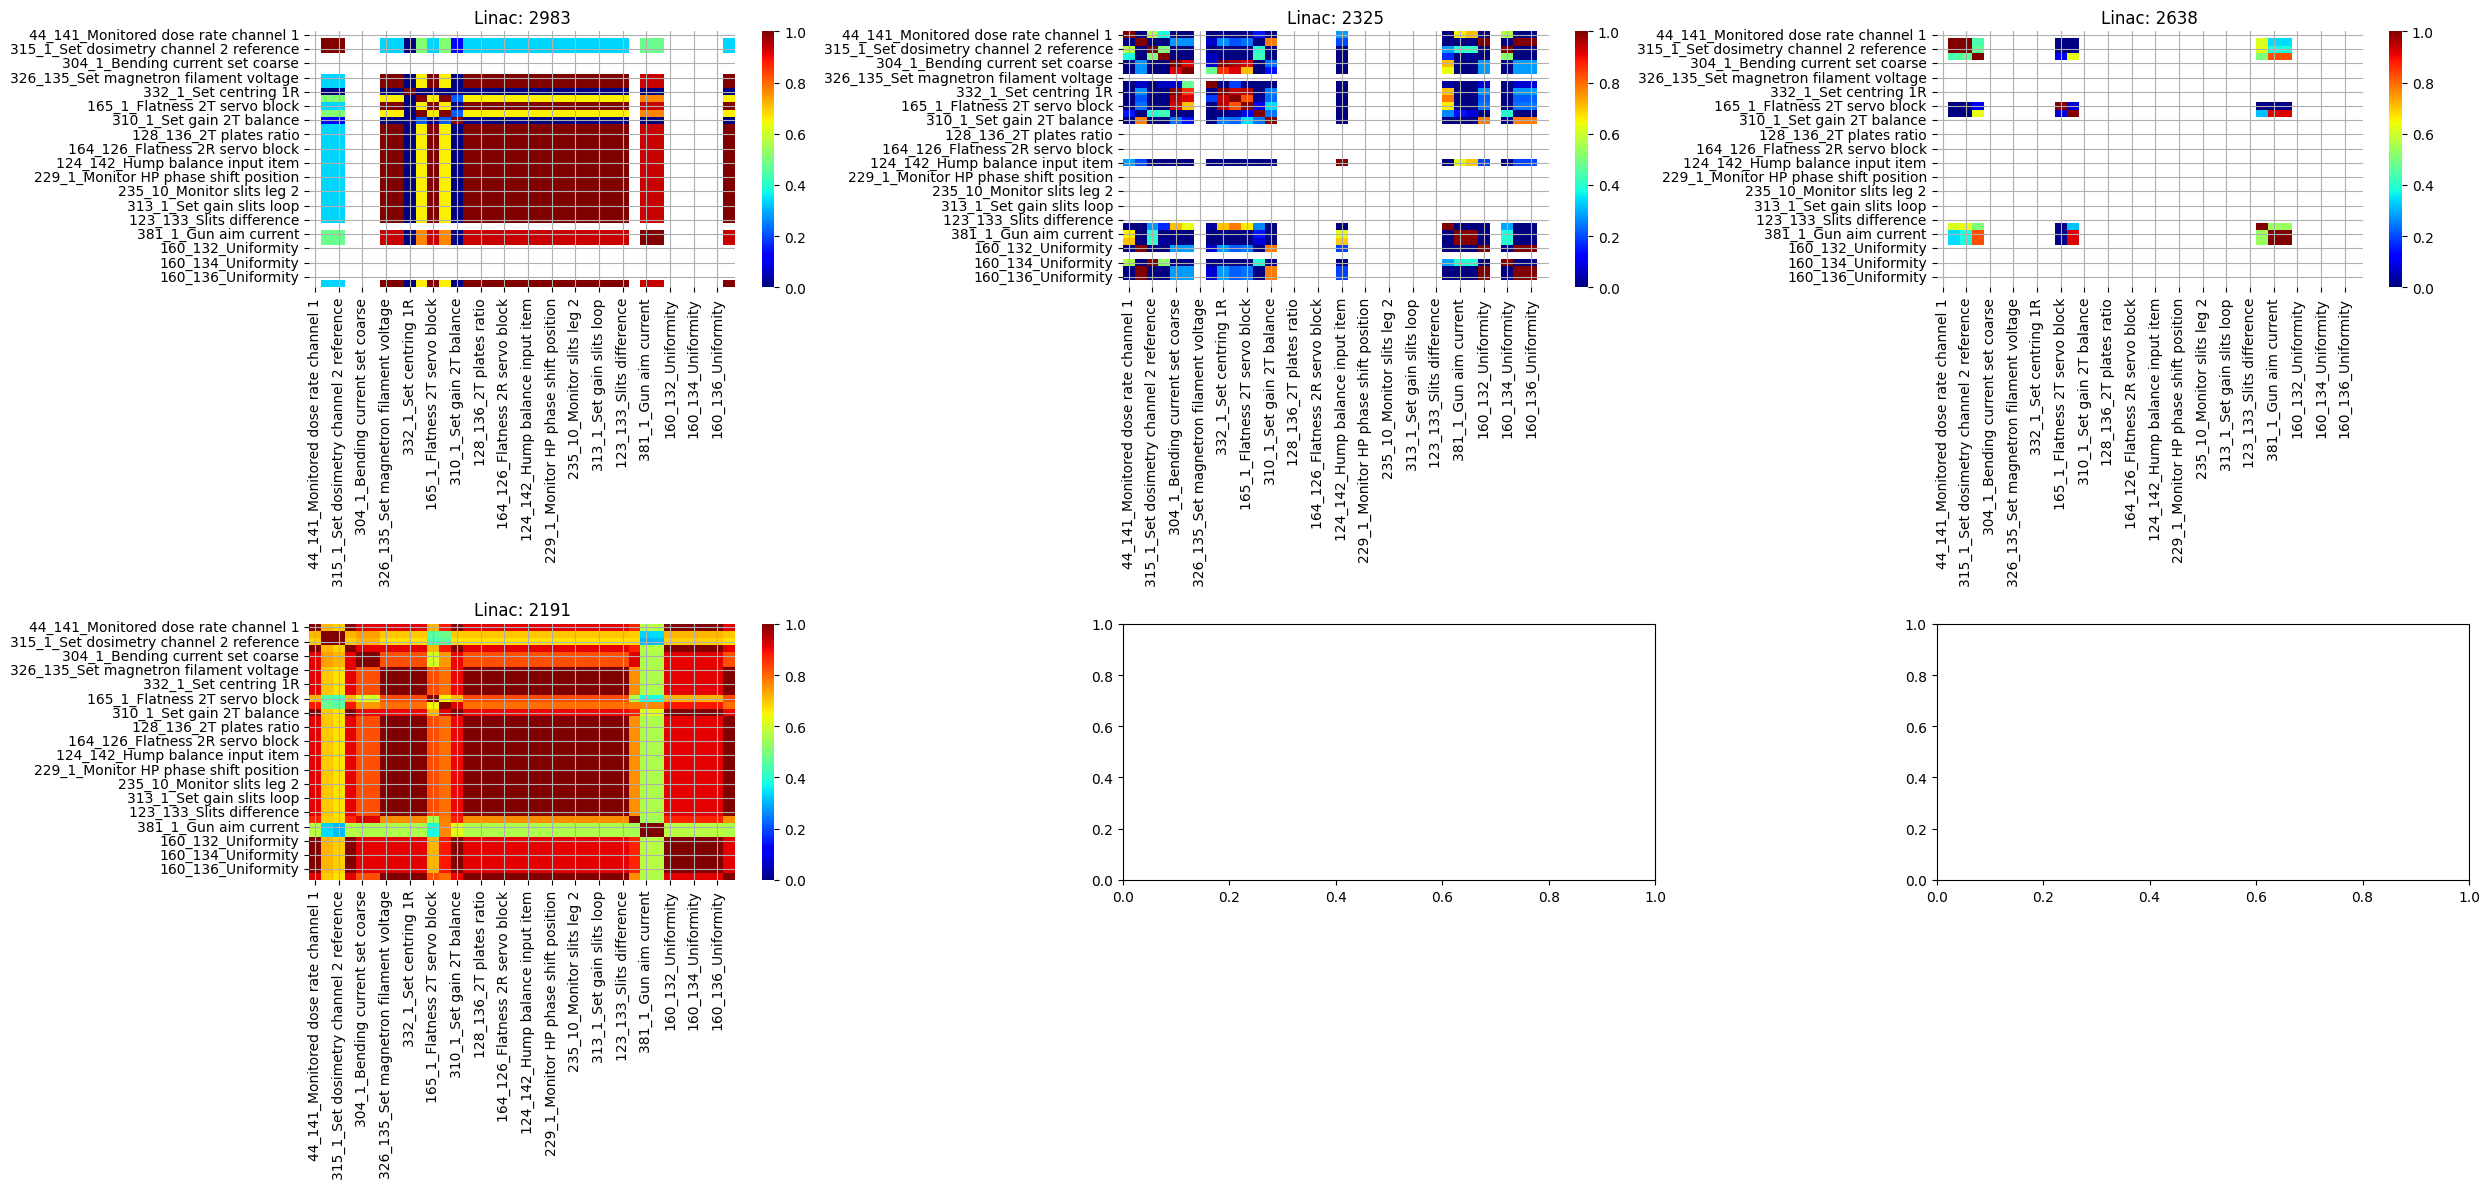

In [248]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 12))
linacs = list(set(pivoted["linac"]))

for num in range(len(linacs)):
    row, col = divmod(num, 3)
    corr = pivoted[pivoted["linac"] == linacs[num]].set_index(["date", "linac"]).corr()
    sns.heatmap(corr, cmap="jet", vmin=0.0, vmax=1.0, ax=axes[row, col], )
    axes[row, col].set_title(f"Linac: {linacs[num]}")
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()


De items die in 1 linac een verband hebben, is dit verband in de volgende linac compleet anders.

In [249]:
pivoted_05 = changes_df.pivot(index=["date","linac"], columns=["item", "part", "category"], values="value")


# Flatten column names
pivoted_05.columns = [
    '_'.join(map(str, col)).strip() if isinstance(col, tuple) else col
    for col in pivoted_05.columns
]

# Rename the incorrectly flattened date/linac columns
pivoted_05 = pivoted_05.rename(columns={"date__": "date", "linac__": "linac"})

pivoted_05 = pivoted_05.reset_index()


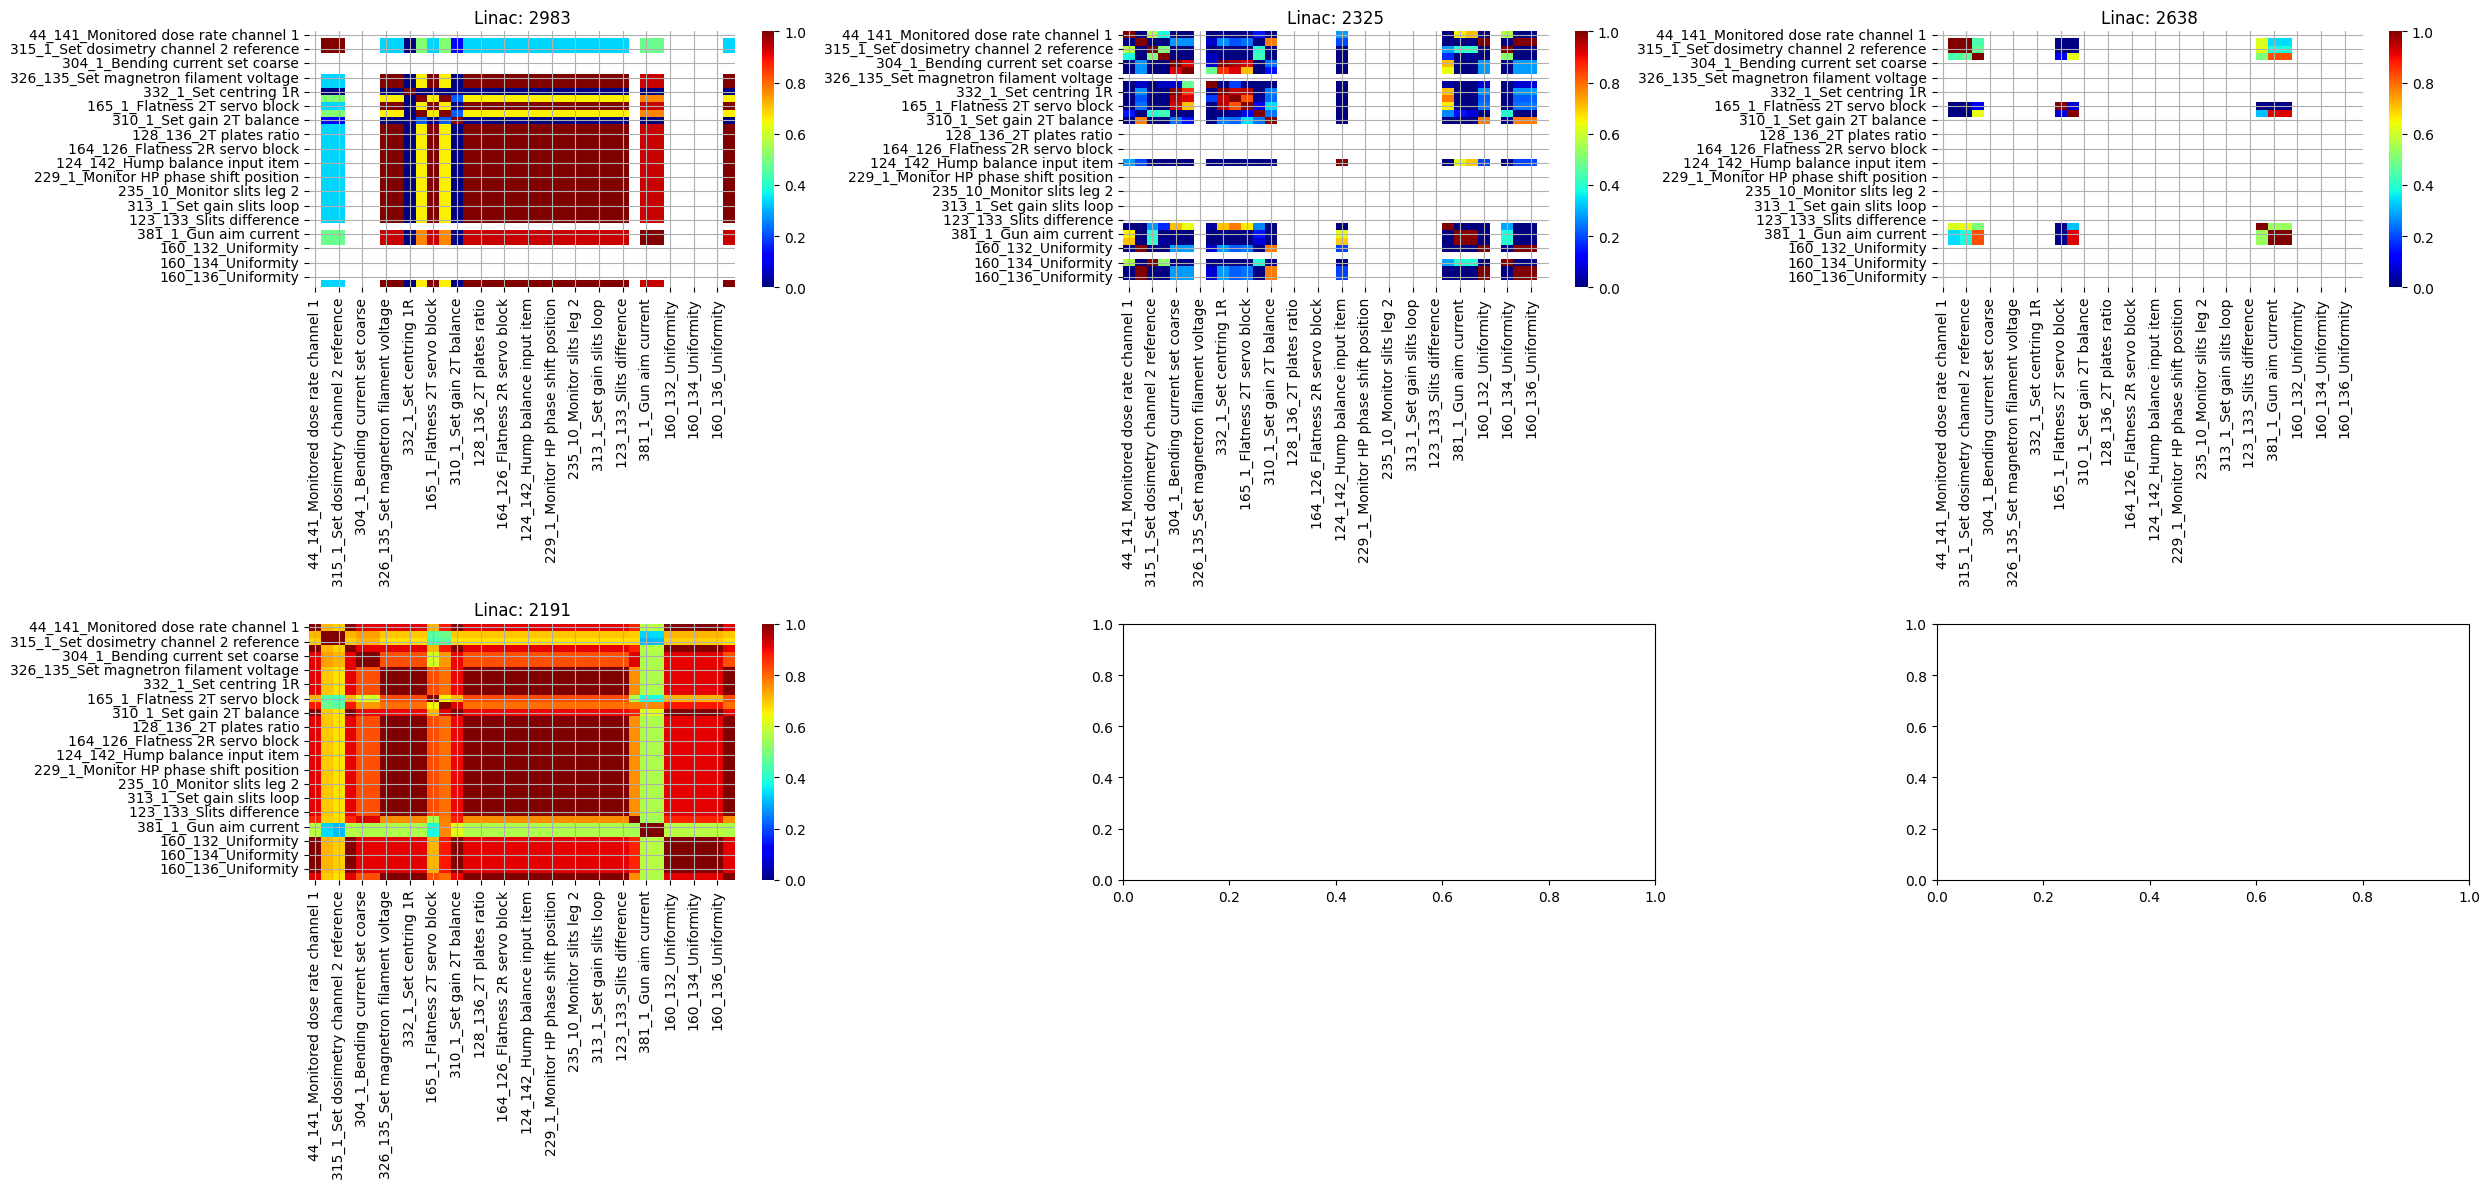

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 12))
linacs = list(set(pivoted_05["linac"]))

for num in range(len(linacs)):
    row, col = divmod(num, 3)
    corr = pivoted_05[pivoted_05["linac"] == linacs[num]].set_index(["date", "linac"]).corr()
    sns.heatmap(corr, cmap="jet", vmin=0.0, vmax=1.0, ax=axes[row, col], )
    axes[row, col].set_title(f"Linac: {linacs[num]}")
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()


De matrixen zijn in een snel overzicht redelijke het zelfde.

### Het model

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest


In [252]:
df_ml = pivoted[pivoted["linac"] == 2191].set_index(["date", "linac"])

df_ml = df_ml.drop("2025-04-30")

y = df_ml["381_1_Gun aim current"]
X = df_ml.drop("381_1_Gun aim current", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
	

In [253]:
models= [
    LinearRegression,
    RandomForestRegressor,
    SVR,
    GaussianProcessRegressor,
    BayesianRidge
]

metric_scores = {}
for model in models:
    scores = cross_validate(model(), X, y, return_train_score=True)
    for key, val in scores.items():
        scores[key] = val.mean()
    metric_scores[f"{model.__name__}"] = scores
    
pd.DataFrame(metric_scores).T

fit_time  score_time     test_score  train_score
LinearRegression          0.005521    0.003558       0.795909     0.999849
RandomForestRegressor     0.227436    0.021549      -5.514929     0.990719
SVR                       0.003849    0.003133     -15.662284     0.374844
GaussianProcessRegressor  0.005417    0.003878 -100486.682939     1.000000
BayesianRidge             0.005328    0.002956       0.948049     0.999833

In [254]:
metric_scores = {}
k = 22
while k:
    X_select = SelectKBest(k=k).fit_transform(X, y)
    scores = cross_validate(BayesianRidge(), X_select, y, return_train_score=True)
    for key, val in scores.items():
        scores[key] = val.mean()
    metric_scores[f"{k} features"] = scores
    k -= 1

kbest = pd.DataFrame(metric_scores).T


c:\Users\Laris\miniconda3\envs\stage\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning:

divide by zero encountered in divide

c:\Users\Laris\miniconda3\envs\stage\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning:

divide by zero encountered in divide

c:\Users\Laris\miniconda3\envs\stage\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning:

divide by zero encountered in divide

c:\Users\Laris\miniconda3\envs\stage\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning:

divide by zero encountered in divide

c:\Users\Laris\miniconda3\envs\stage\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning:

divide by zero encountered in divide

c:\Users\Laris\miniconda3\envs\stage\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning:

divide by zero encountered in divide

c:\U

In [255]:
kbest[kbest["test_score"] > 0.90].sort_values(by="test_score", ascending=False)

fit_time  score_time  test_score  train_score
9 features   0.002659    0.001316    0.941749     0.999634
6 features   0.002615    0.001375    0.941202     0.999599
7 features   0.002679    0.001487    0.940803     0.999628
8 features   0.002662    0.001471    0.940797     0.999628
10 features  0.002743    0.001380    0.934483     0.999659
22 features  0.003564    0.001446    0.909748     0.999683
16 features  0.003034    0.001453    0.909747     0.999683
15 features  0.003097    0.001414    0.909747     0.999683
14 features  0.002947    0.001378    0.909747     0.999683
19 features  0.003055    0.001278    0.909747     0.999683
17 features  0.003713    0.001396    0.909747     0.999683
18 features  0.002939    0.001400    0.909747     0.999683
21 features  0.003440    0.001345    0.909747     0.999683
20 features  0.003108    0.001356    0.909746     0.999683

R²-score: 0.9988864782066066
RMSE: 0.4055651320545115


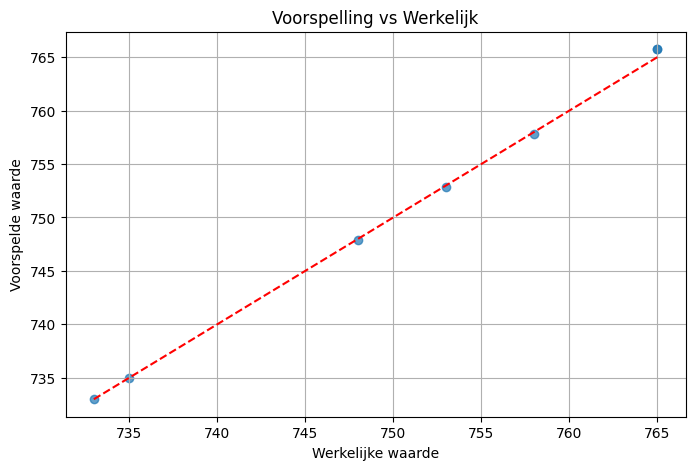

In [256]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error

# Stel het aantal beste features in (bijvoorbeeld hoogste test R² uit kbest_df)
best_k = 5

# Split opnieuw
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# SelectKBest toepassen
selector = SelectKBest(score_func=f_regression, k=best_k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Model trainen
model = BayesianRidge()
model.fit(X_train_selected, y_train)

# Voorspellingen maken
y_pred = model.predict(X_test_selected)

# Evaluatie
print("R²-score:", r2_score(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# (Optioneel) Plot resultaten
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Werkelijke waarde")
plt.ylabel("Voorspelde waarde")
plt.title("Voorspelling vs Werkelijk")
plt.grid(True)
plt.show()


Dit voorspelt nu als je de hele data er in doet, wat de item 381 gaat doen. maar ja als het wordt aangepast, wordt die ook aangepast. je kan er mee voorspellen of die doet wat verwacht wordt...

moet iets hebben dat de lijn ziet, en de andere waarde meeneemt en daarmee de loop van de lijn kan voorspellen.

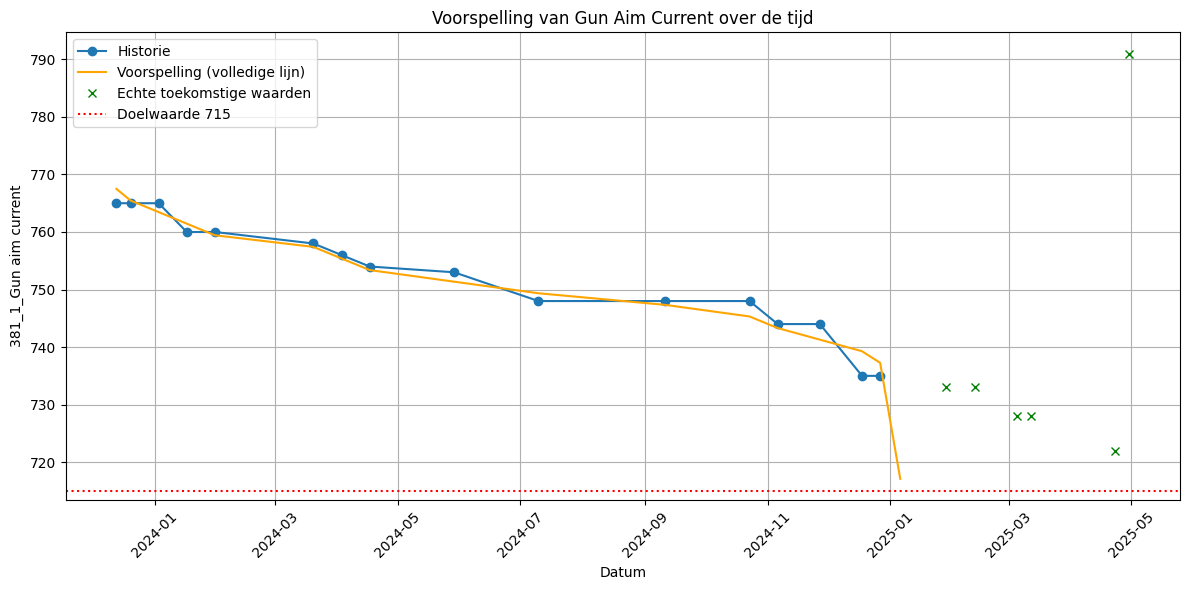

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge

# Filter en sorteer de data
df = pivoted[pivoted["linac"] == 2191].copy()
df = df.set_index("date").sort_index()

# Data die als 'toekomstig' moet worden gebruikt voor controle
true_dates = ["2025-04-30", "2025-03-12", "2025-03-05", "2025-02-12", "2025-01-29", "2025-04-23"]
true_future = df.loc[true_dates]
y_true = true_future["381_1_Gun aim current"]
y_true.index = pd.to_datetime(y_true.index)

# Historische data voor training
df = df.drop(true_dates)
y = df["381_1_Gun aim current"]
y.index = pd.to_datetime(y.index)

# Zet datum om naar numeriek voor regressie (tijd als index)
X = np.arange(len(y)).reshape(-1, 1)

# Train het regressiemodel
model = BayesianRidge()
model.fit(X, y)

# Hoeveel dagen voorspellen?
future_steps = 10
X_future = np.arange(len(y), len(y) + future_steps).reshape(-1, 1)
y_future_pred = model.predict(X_future)

# Combineer voor een lijn over de hele tijdsreeks
X_full = np.arange(len(y) + future_steps).reshape(-1, 1)
y_full_pred = model.predict(X_full)

# Datumreeks voor alles
future_dates = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=future_steps)
all_dates = y.index.tolist() + future_dates.tolist()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y.index, y.values, label="Historie", marker="o")
plt.plot(all_dates, y_full_pred, label="Voorspelling (volledige lijn)", linestyle="-", color="orange")
plt.plot(y_true.index, y_true.values, label="Echte toekomstige waarden", marker="x", linestyle="None", color="green")
plt.axhline(715, color='red', linestyle=':', label="Doelwaarde 715")

plt.xlabel("Datum")
plt.ylabel("381_1_Gun aim current")
plt.xticks(rotation=45)
plt.title("Voorspelling van Gun Aim Current over de tijd")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


BE63

Dit zijn calibratie bestanden, elk bestand heeft 697 items met 1 part nummer.

In [258]:
files = merged_df[merged_df["file_name"].str.contains("Be63")]["file_name"].unique().tolist()
data = {}
dates = []

for file in files:
    part = merged_df[merged_df["file_name"] == file]["part"].unique().tolist()
    dates.append(merged_df[merged_df["file_name"] == file]["date"].unique().tolist())
    data[file] = part

#df with the part number
partnum = pd.DataFrame(data).T.rename(columns={0 :"Part"}).reset_index()


partnum["Amount of dates"] = [len(date) for date in dates]

#add translation of the part
dfitem_parts = pd.read_csv("data/Itemparts.csv")

partnum = partnum.merge(dfitem_parts[["Part No.", "Part Name", "Description"]], how="left", left_on="Part", right_on= "Part No.").drop(columns=["Part No."]).set_index("index")
partnum


Part  Amount of dates               Part Name  \
index                                                   
Be6300    18                3               Item type   
Be6302     2                3          Tolerance high   
Be6303     6                3           Tolerance low   
Be6304    13                3          Access pointer   
Be6305    17               25       Default frequency   
Be6306    14                3             Access mask   
Be6308    15                3             Action mask   
Be6310    10               25      Calibration offset   
Be6311    11               25        Calibration gain   
Be6312    12               25     Calibration inverse   
Be6313    16               25        Parent interlock   
Be6315    38               25            Coupled item   
Be6316    39               25            Coupled part   
Be6317   141               25                  Gain 1   
Be6317   141               25                  Gain 1   
Be6317   141               25                  Gain 1   
Be6318   142               25                  Gain 2   
Be6318   142               25                  Gain 2   
Be6318   142               25                  Gain 2   
Be6328    19               25  Calibration limit high   
Be6329    20               25   Calibration limit low   
Be6330   123                3     Absolute high limit   
Be6331   124                3      Absolute low limit   

                                              Description  
index                                                      
Be6300          This part defines how an item is treated.  
Be6302  This part sets the high limit of the value in ...  
Be6303  This part sets the low limit of the value in p...  
Be6304  This part is the index to all fac 1 arrays and...  
Be6305         This part defines default frequency queue.  
Be6306  This part is used to distinguish between incom...  
Be6308  This part determines the action to be taken wh...  
Be6310  This part is the offset value that is applied ...  
Be6311  This part is the gain value that is applied to...  
Be6312  This part is the inverse gain value that is ap...  
Be6313  This part defines hierarchy of interlocks. If ...  
Be6315  This part enables control of a particular item...  
Be6316  This part enables control of a particular part...  
Be6317  The function of p141 varies, depending on the ...  
Be6317                     The positional loop gain value  
Be6317                      The coarse potentiometer gain  
Be6318  The function of part 142 varies, depending on ...  
Be6318  The output or loop gain (for example, calibrat...  
Be6318                        The fine potentiometer gain  
Be6328           This part is the calibrated upper limit.  
Be6329           This part is the calibrated lower limit.  
Be6330  This part is the upper design limit. The part ...  
Be6331  This part is the lower design limit. The part ...

In [ ]:
# remove the ones with 3 dates cause those have to little to look at
partnum = partnum[partnum["Amount of dates"] > 3]

In [321]:
total_changes = []
for file in partnum.index:
    be6300 = merged_df[merged_df["file_name"] == file].copy()
    be6300["Part&item"] = "I:"+ be6300["item"].astype(str) + " P:"+ be6300["part"].astype(str)

    nop45 = be6300[be6300["part"] != 45]

    for linac in list(set(nop45["linac"])):
        result = pd.DataFrame()

        linec_df = nop45[nop45["linac"] == linac]
        dates = list(set(linec_df["date"]))

        for item in range(len(dates)-1):
            old = linec_df[linec_df["date"] == dates[item]]
            new = linec_df[linec_df["date"] == dates[item+1]]

            diff = new["value"].values - old["value"].values
            temp = pd.DataFrame({
                "date": new["date"].tolist(),
                "difference": diff,
                "PI": new["Part&item"],
                "linac": new["linac"]
            })

            result = pd.concat([temp, result])
            

    changed = result[result["difference"] != 0]

    changes = changed["PI"].unique().tolist()

    total_changes.append(changes)

    #only the changed combination of part and item
    changes_df = be6300[be6300["Part&item"].isin(changes)]


partnum["veranderingen"] = [len(change) for change in total_changes]
partnum

C:\Users\Laris\AppData\Local\Temp\ipykernel_9072\2342806455.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Part  Amount of dates               Part Name  \
index                                                   
Be6305    17               25       Default frequency   
Be6310    10               25      Calibration offset   
Be6311    11               25        Calibration gain   
Be6312    12               25     Calibration inverse   
Be6313    16               25        Parent interlock   
Be6315    38               25            Coupled item   
Be6316    39               25            Coupled part   
Be6317   141               25                  Gain 1   
Be6317   141               25                  Gain 1   
Be6317   141               25                  Gain 1   
Be6318   142               25                  Gain 2   
Be6318   142               25                  Gain 2   
Be6318   142               25                  Gain 2   
Be6328    19               25  Calibration limit high   
Be6329    20               25   Calibration limit low   

                                              Description  veranderingen  
index                                                                     
Be6305         This part defines default frequency queue.              0  
Be6310  This part is the offset value that is applied ...              7  
Be6311  This part is the gain value that is applied to...              1  
Be6312  This part is the inverse gain value that is ap...              1  
Be6313  This part defines hierarchy of interlocks. If ...              0  
Be6315  This part enables control of a particular item...             10  
Be6316  This part enables control of a particular part...              3  
Be6317  The function of p141 varies, depending on the ...             12  
Be6317                     The positional loop gain value             12  
Be6317                      The coarse potentiometer gain             12  
Be6318  The function of part 142 varies, depending on ...              6  
Be6318  The output or loop gain (for example, calibrat...              6  
Be6318                        The fine potentiometer gain              6  
Be6328           This part is the calibrated upper limit.             31  
Be6329           This part is the calibrated lower limit.             27

C:\Users\Laris\AppData\Local\Temp\ipykernel_9072\2357291640.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2983
2325
2638
2191


item                             33                          34   \
part                              19                          19   
category Beam dose channel 1 monitor Beam dose channel 2 monitor   
count                          13.00                       13.00   
mean                        11564.08                    11570.69   
std                         15154.50                    15156.49   
min                             0.00                        0.00   
25%                            21.00                       22.00   
50%                           164.00                      183.00   
75%                         29981.00                    29990.00   
max                         29981.00                    29990.00   
count                           5.00                        5.00   
mean                        18028.80                    18034.80   
std                         16366.38                    16370.49   
min                             0.00                        0.00   
25%                           201.00                      204.00   
50%                         29981.00                    29990.00   
75%                         29981.00                    29990.00   
max                         29981.00                    29990.00   
count                           4.00                        4.00   
mean                        29981.00                    29990.00   
std                             0.00                        0.00   
min                         29981.00                    29990.00   
25%                         29981.00                    29990.00   
50%                         29981.00                    29990.00   
75%                         29981.00                    29990.00   
max                         29981.00                    29990.00   
count                           5.00                        5.00   
mean                        12070.20                    12081.60   
std                         16350.39                    16348.23   
min                            21.00                       22.00   
25%                           167.00                      186.00   
50%                           201.00                      220.00   
75%                         29981.00                    29990.00   
max                         29981.00                    29990.00   

item                   130        160           199                 200  \
part                    19         19            19                  19   
category Table angle start Uniformity Wedge monitor Target type monitor   
count                13.00      13.00         13.00               13.00   
mean                243.00   25216.92          2.77               22.08   
std                   0.00   14347.35          0.44                1.75   
min                 243.00      50.00          2.00               19.00   
25%                 243.00   32767.00          3.00               23.00   
50%                 243.00   32767.00          3.00               23.00   
75%                 243.00   32767.00          3.00               23.00   
max                 243.00   32767.00          3.00               23.00   
count                 5.00       5.00          5.00                5.00   
mean                245.00    6593.40          2.20               19.80   
std                   0.00   14631.49          0.45                1.79   
min                 245.00      50.00          2.00               19.00   
25%                 245.00      50.00          2.00               19.00   
50%                 245.00      50.00          2.00               19.00   
75%                 245.00      50.00          2.00               19.00   
max                 245.00   32767.00          3.00               23.00   
count                 4.00       4.00          4.00                4.00   
mean                244.00      62.50          2.00               19.75   
std                   0.00      25.00       

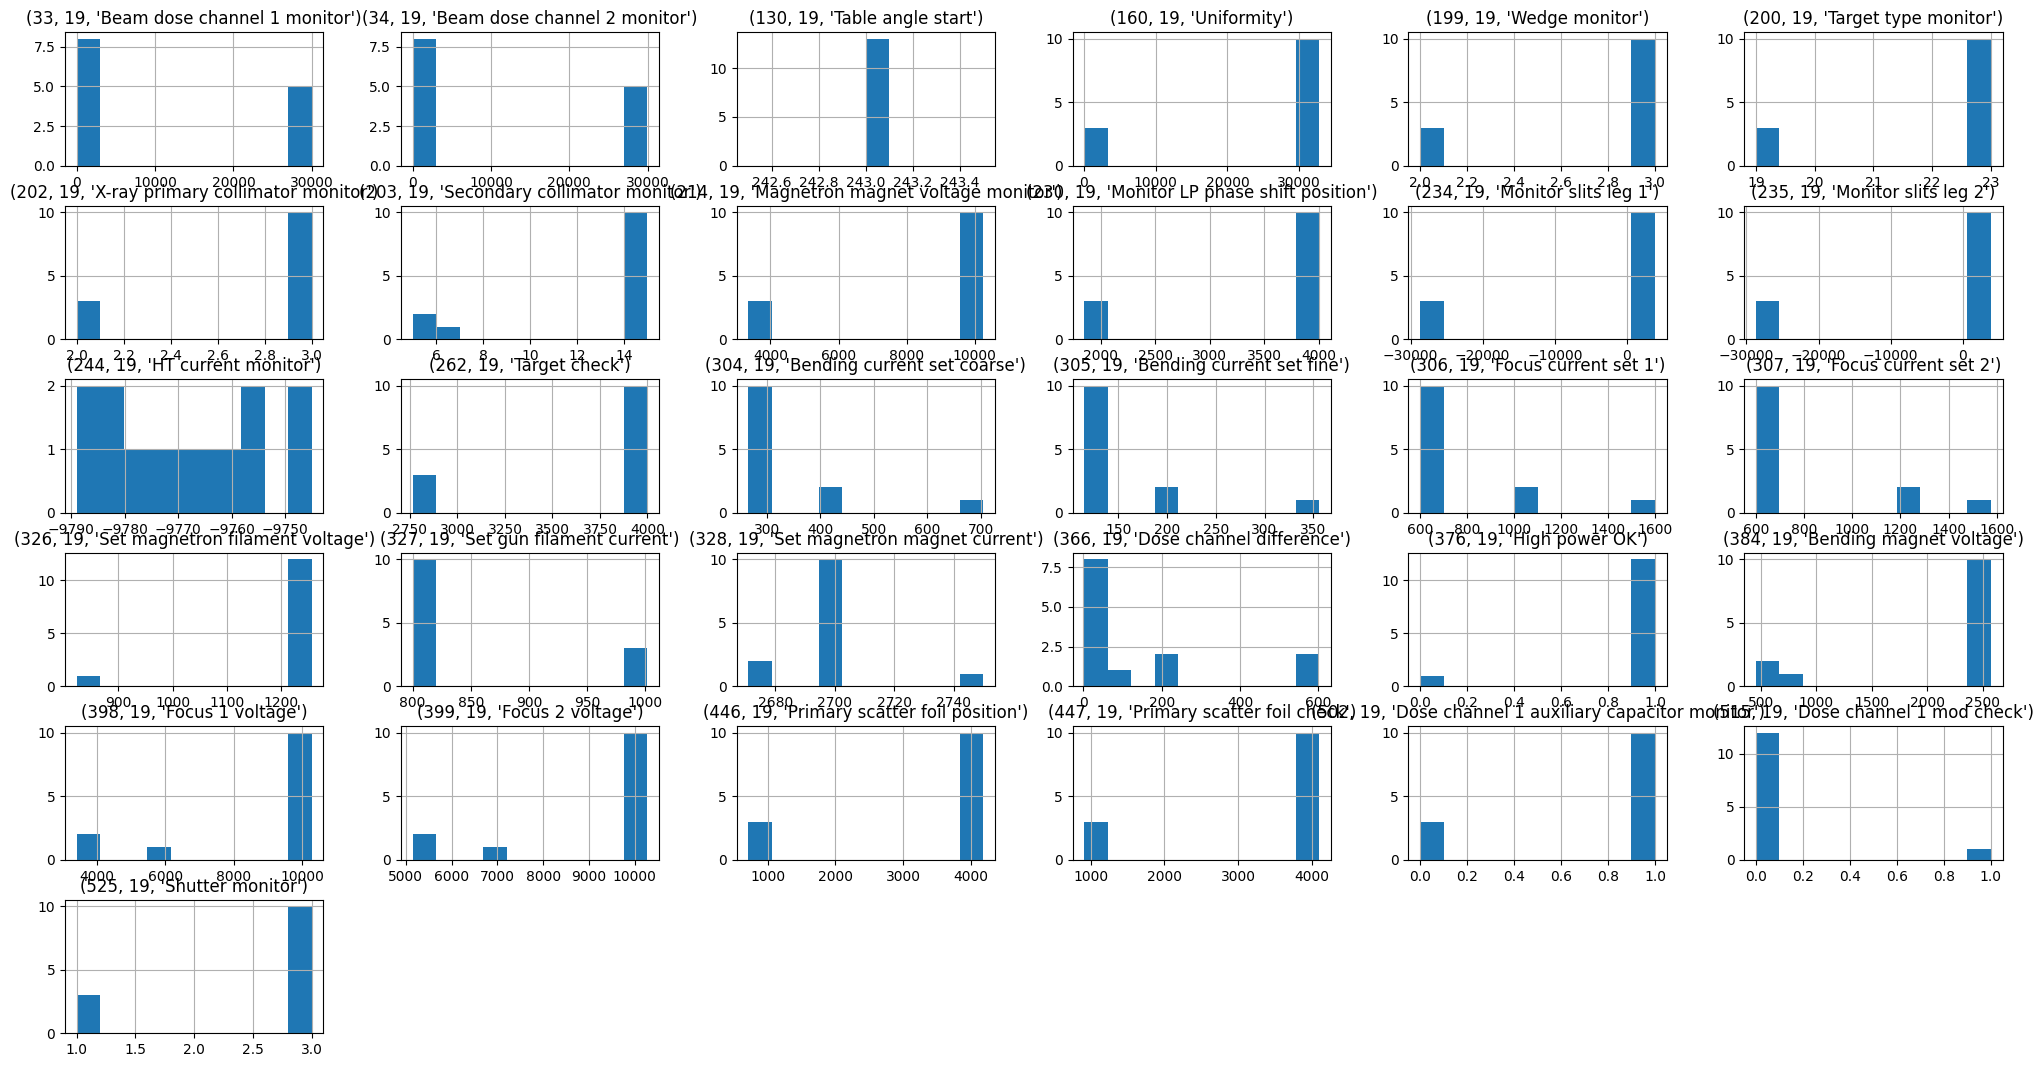

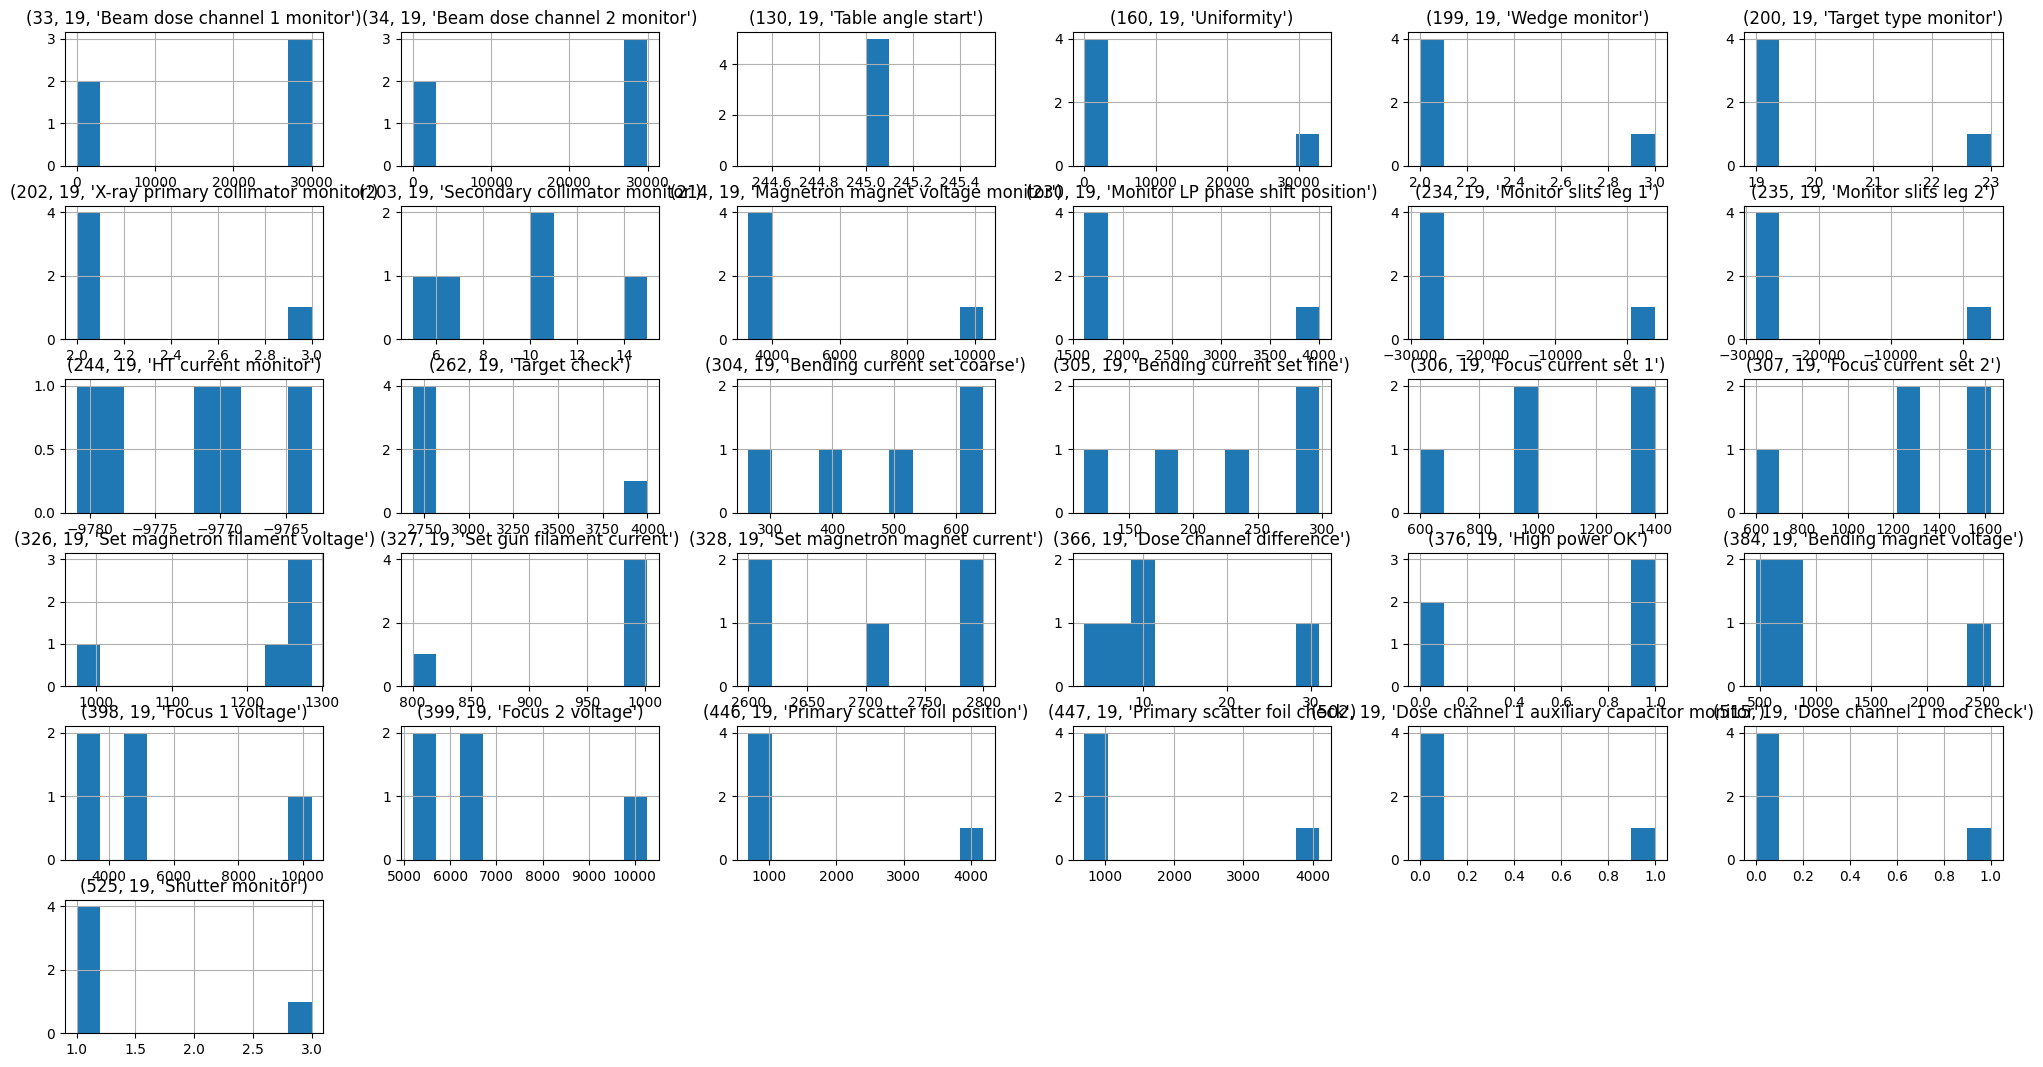

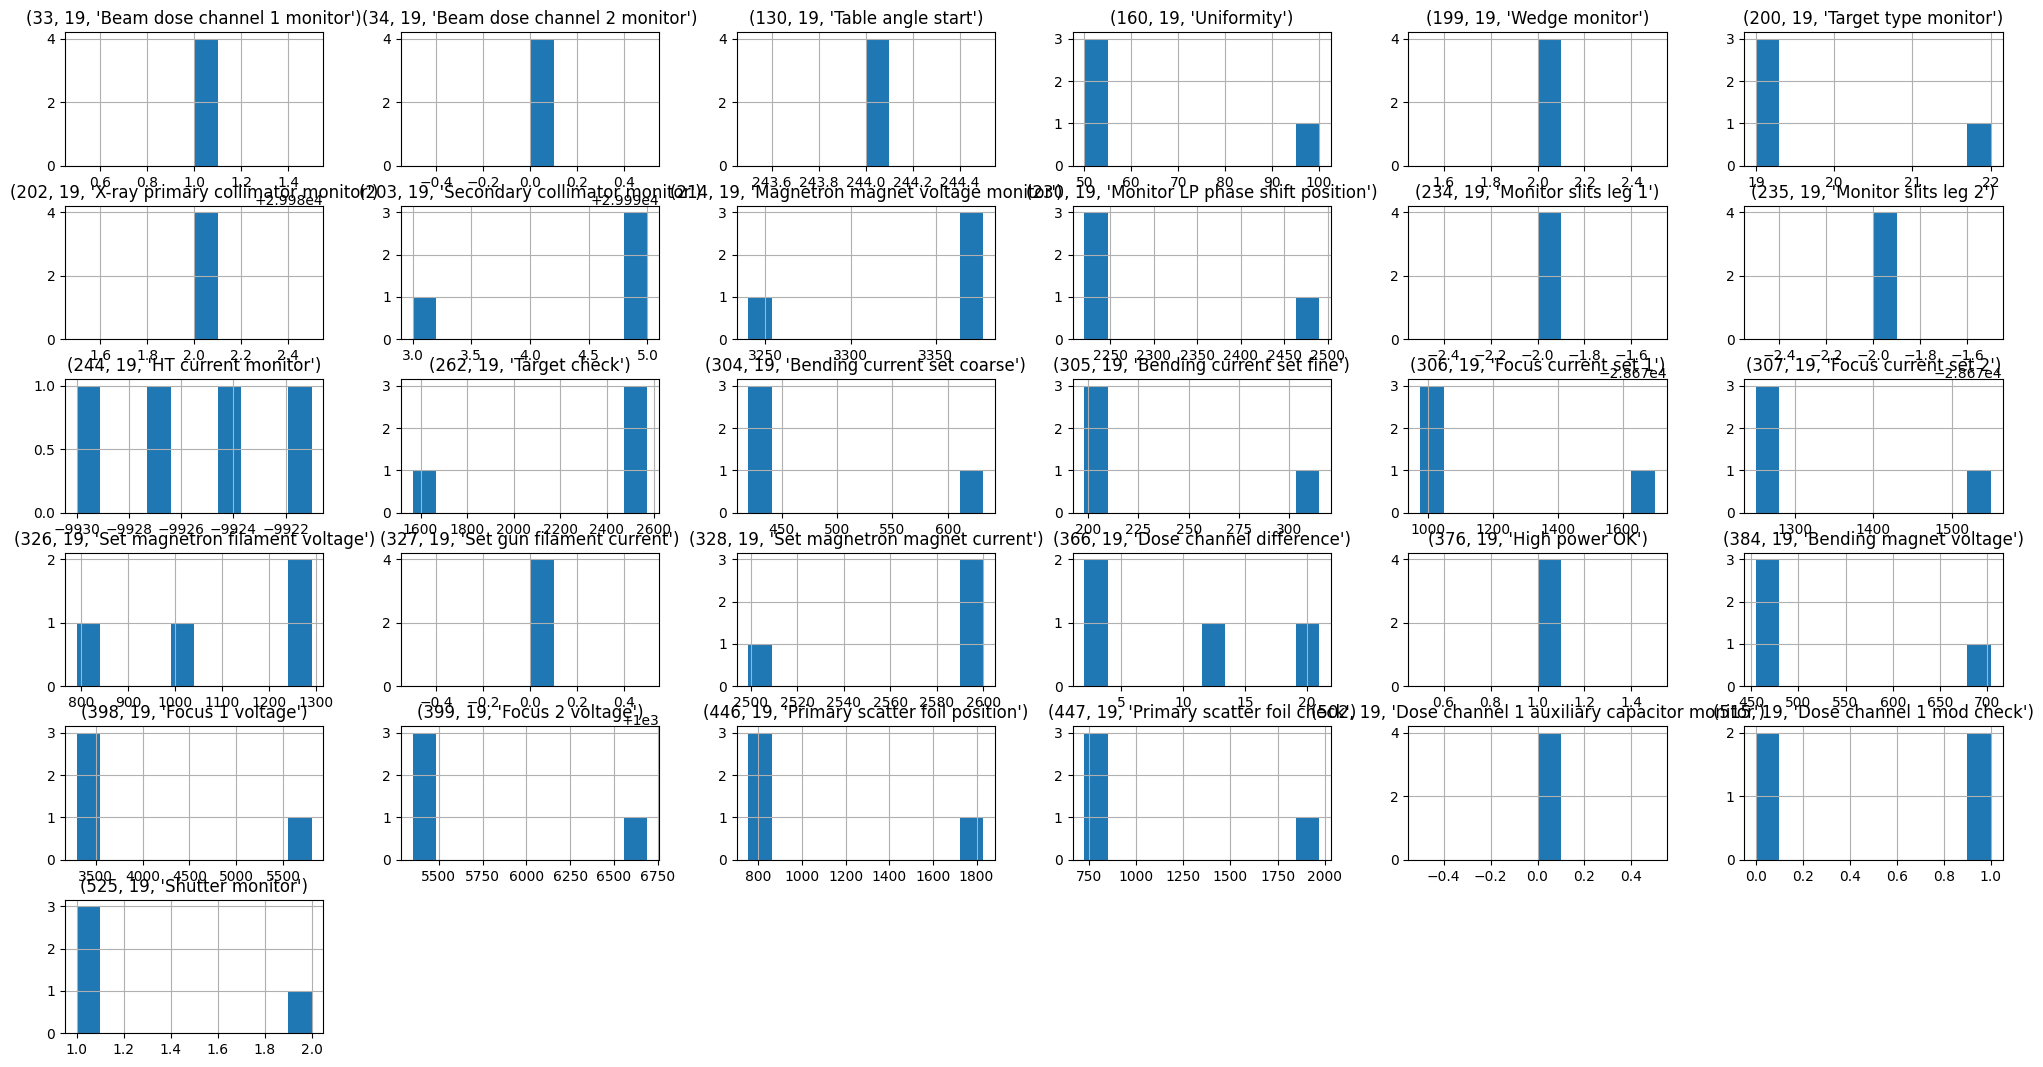

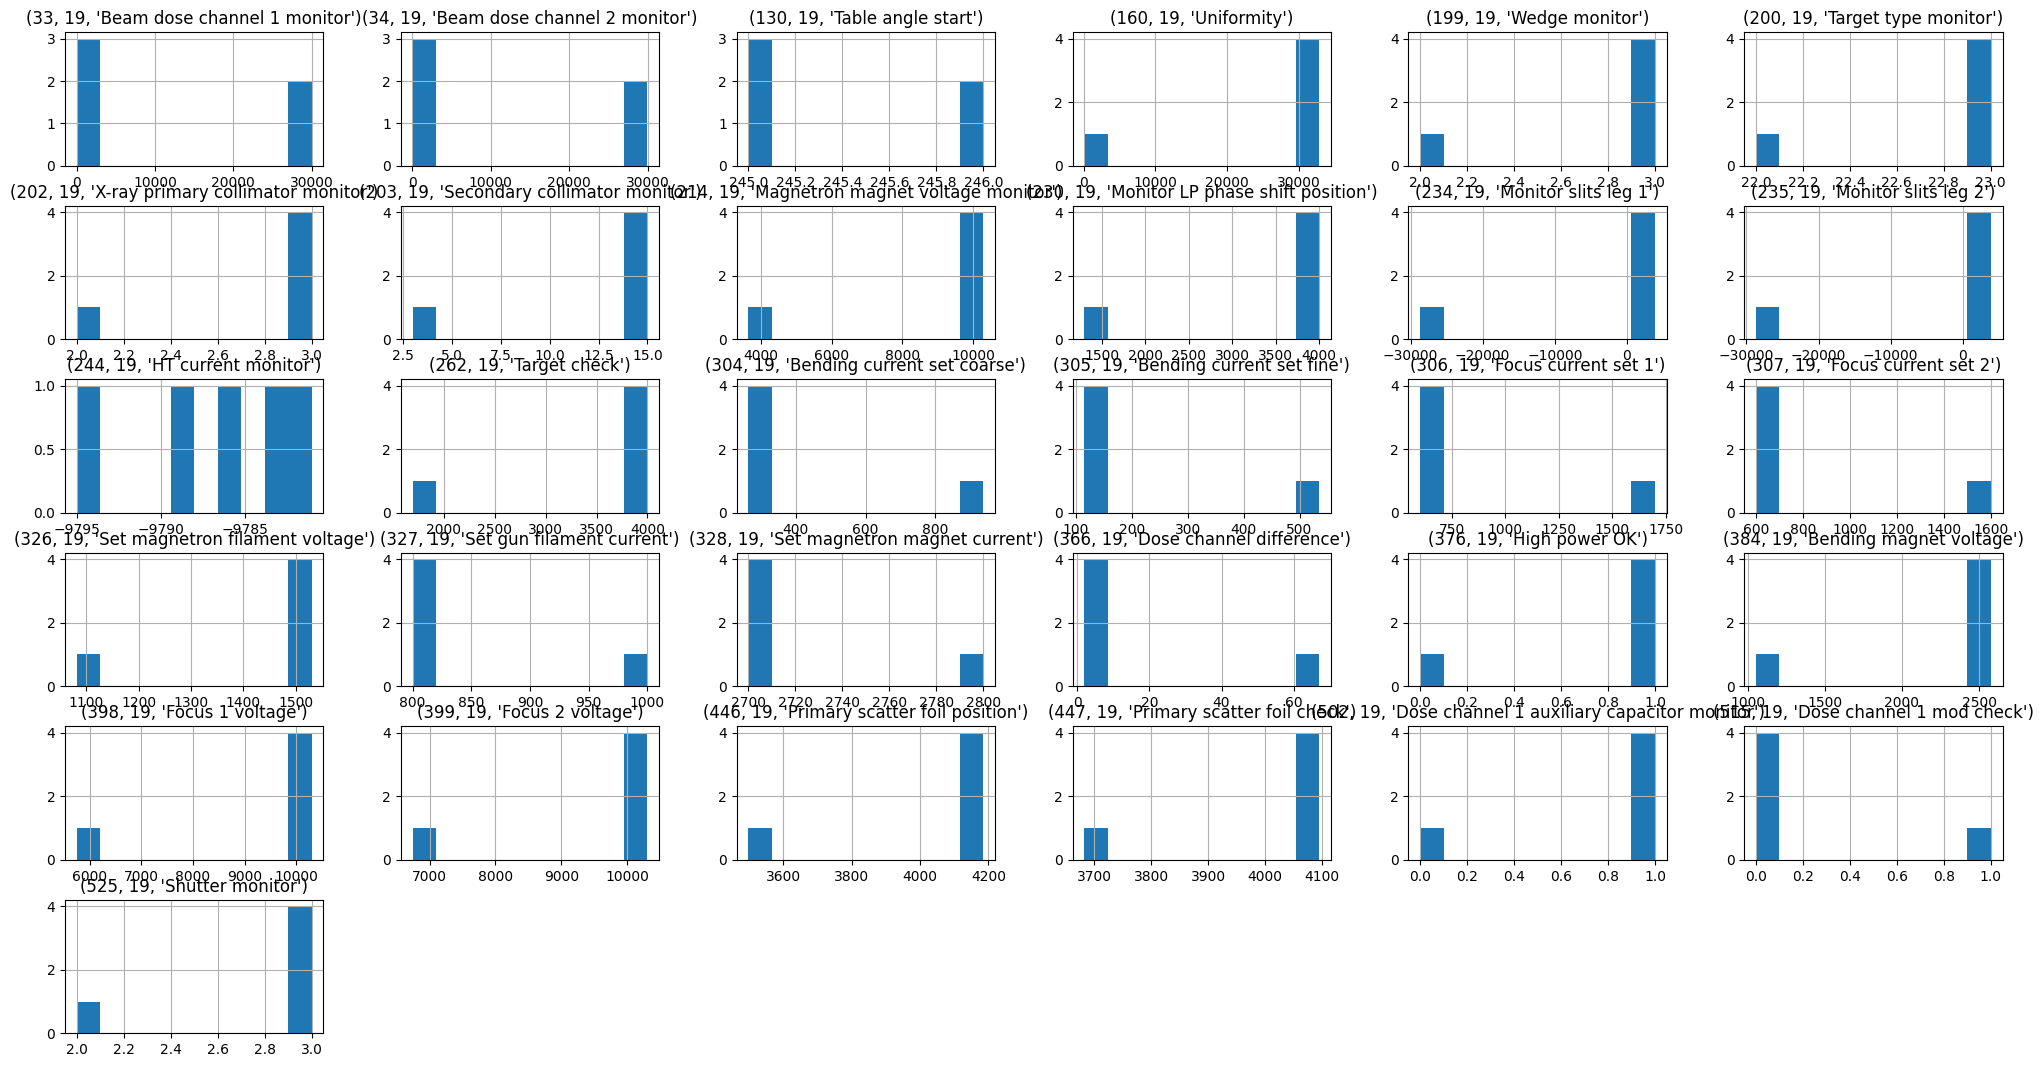

In [264]:
be6300 = merged_df[merged_df["file_name"] == "Be6328"]
be6300["Part&item"] = "I:"+ be6300["item"].astype(str) + " P:"+ be6300["part"].astype(str)

nop45 = be6300[be6300["part"] != 45]

for linac in list(set(nop45["linac"])):
    result = pd.DataFrame()

    linec_df = nop45[nop45["linac"] == linac]
    dates = list(set(linec_df["date"]))

    for item in range(len(dates)-1):
        old = linec_df[linec_df["date"] == dates[item]]
        new = linec_df[linec_df["date"] == dates[item+1]]

        diff = new["value"].values - old["value"].values
        temp = pd.DataFrame({
            "date": new["date"].tolist(),
            "difference": diff,
            "PI": new["Part&item"],
            "linac": new["linac"]
        })

        result = pd.concat([temp, result])
        

changed = result[result["difference"] != 0]

changes = changed["PI"].unique().tolist()

total_changes.append(changes)

#only the changed combination of part and item
changes_df = be6300[be6300["Part&item"].isin(changes)]

show = pd.DataFrame()


# for every linac the describe of the same data
for linac in list(set(changes_df["linac"])):
    print(linac)
    pivoted_be63 = changes_df[changes_df["linac"] == linac].pivot(index="date", columns=["item", "part", "category"], values="value")
    describing = pivoted_be63.describe()
    show = pd.concat([show, describing])
    pivoted_be63.hist(figsize=(25,13));

show.round(2)
   

In [307]:
pivoted_be63 = changes_df.pivot(index=["date", "linac"], columns=["item", "part", "category"], values="value").reset_index()

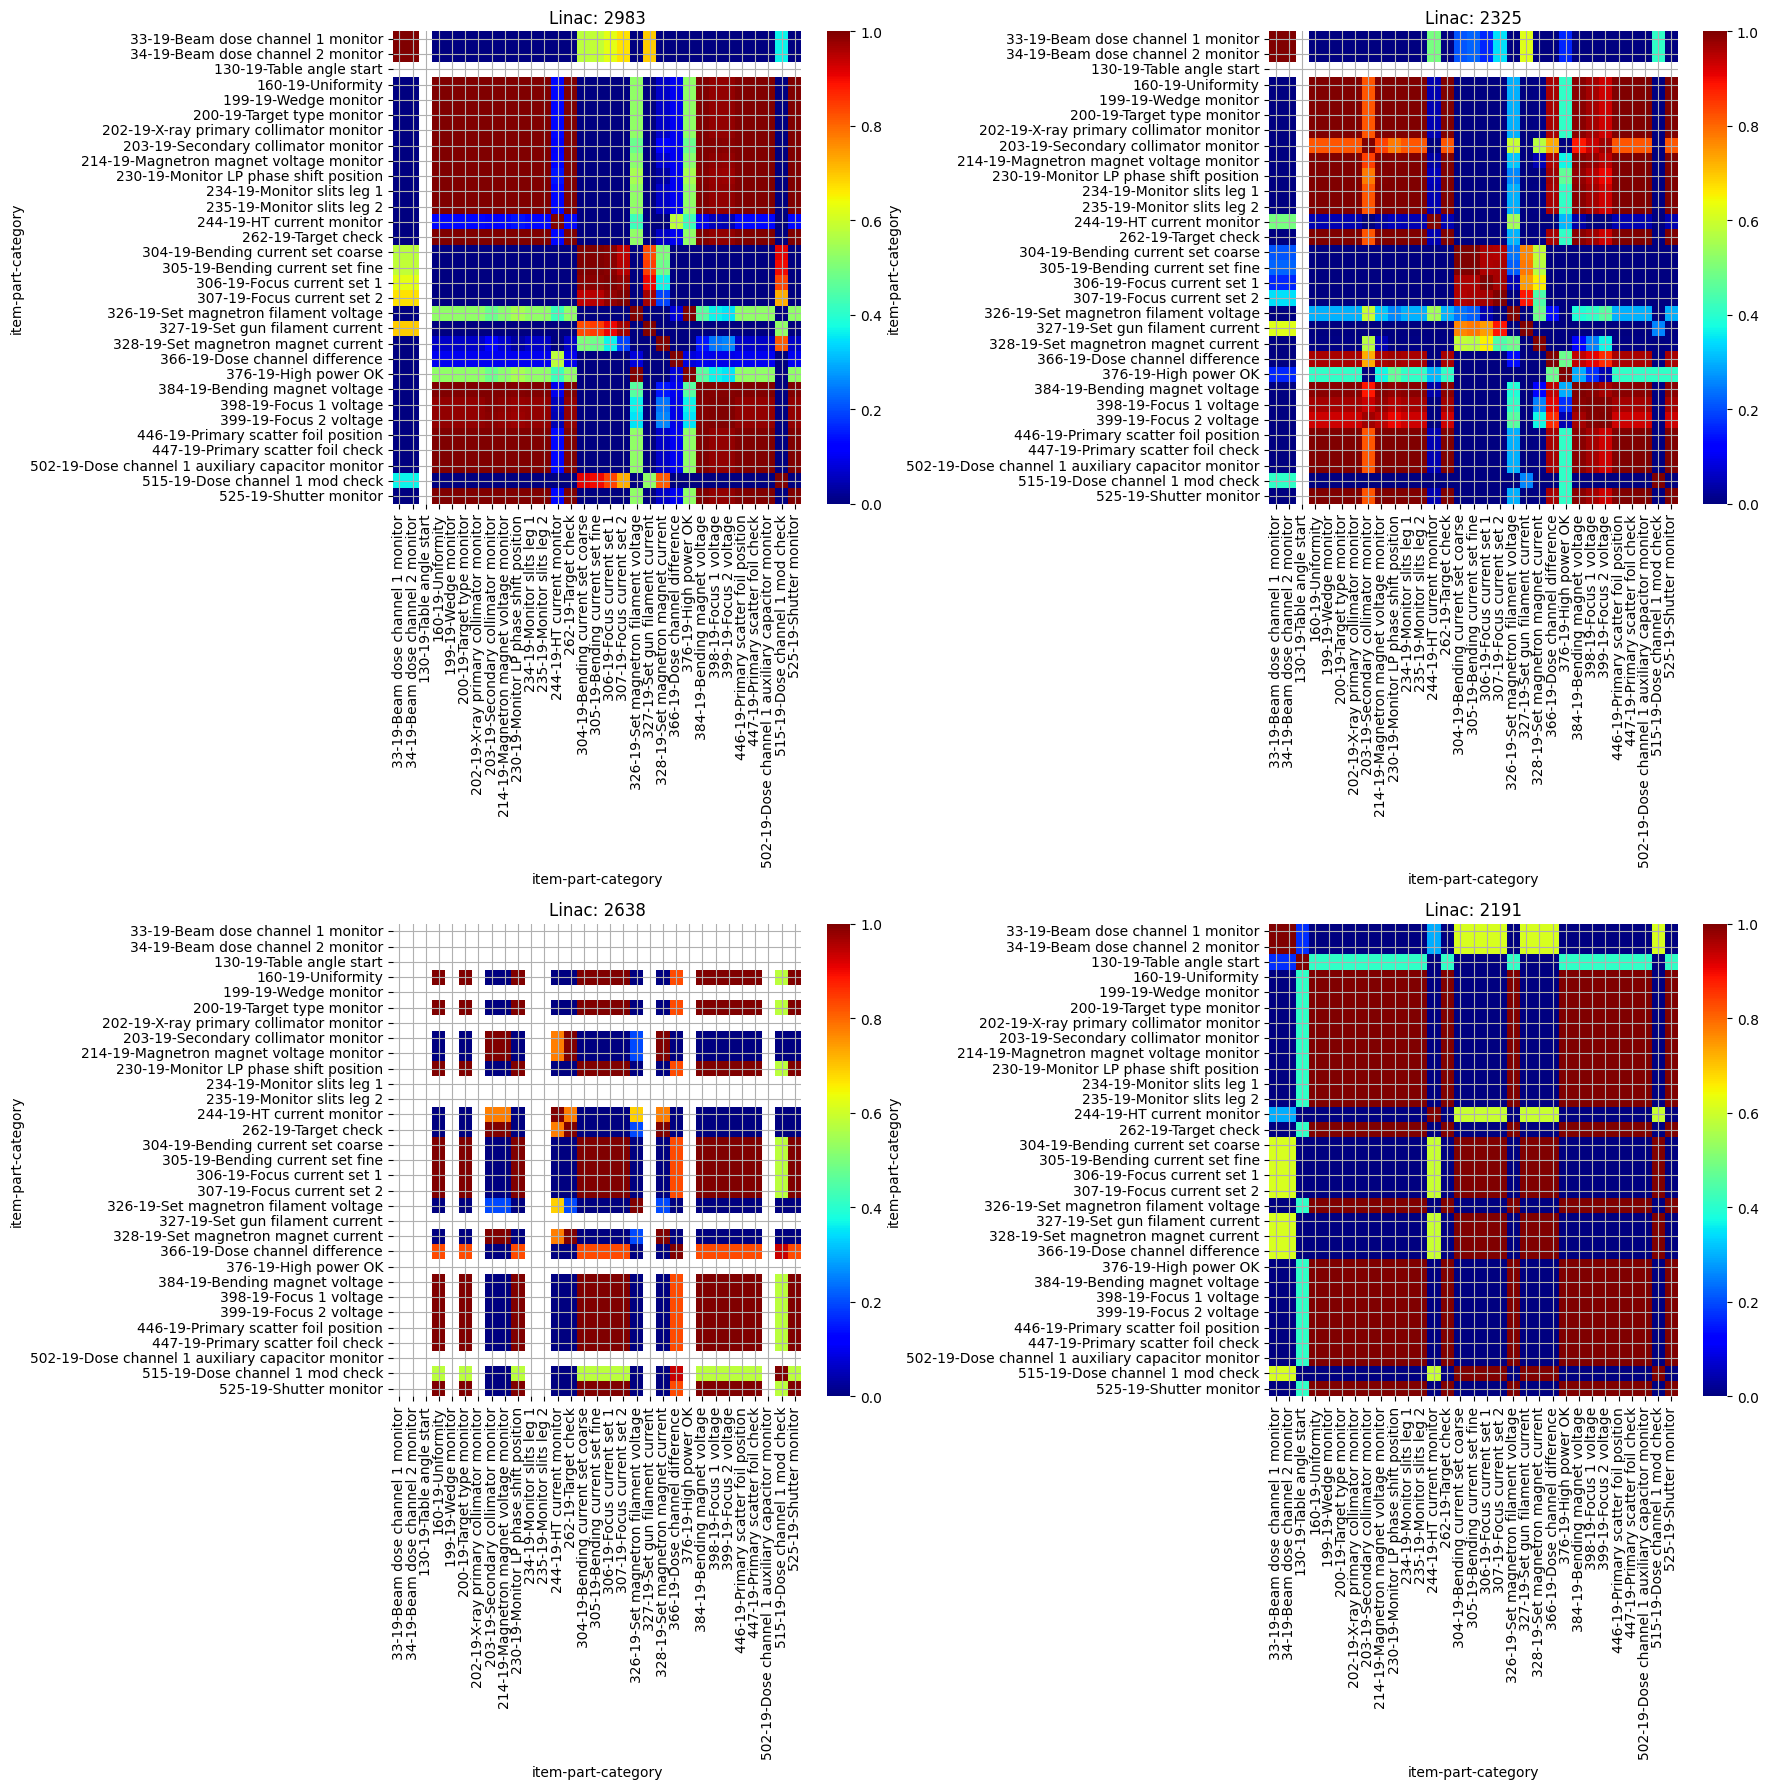

In [313]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))
linacs = list(set(pivoted_be63["linac"]))

for num in range(len(linacs)):
    row, col = divmod(num, 2)
    corr = pivoted_be63[pivoted_be63["linac"] == linacs[num]].set_index(["date", "linac"]).corr()
    sns.heatmap(corr, cmap="jet", vmin=0.0, vmax=1.0, ax=axes[row, col], )
    axes[row, col].set_title(f"Linac: {linacs[num]}")
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()



In [320]:
corr = pivoted_be63[pivoted_be63["linac"] == 2191].set_index(["date", "linac"]).corr()

columns_above_95 = corr_95.columns[(corr_95 > 0.95).any()]



MultiIndex([( 33, 19,                'Beam dose channel 1 monitor'),
            ( 34, 19,                'Beam dose channel 2 monitor'),
            (130, 19,                          'Table angle start'),
            (160, 19,                                 'Uniformity'),
            (199, 19,                              'Wedge monitor'),
            (200, 19,                        'Target type monitor'),
            (202, 19,           'X-ray primary collimator monitor'),
            (203, 19,               'Secondary collimator monitor'),
            (214, 19,           'Magnetron magnet voltage monitor'),
            (230, 19,            'Monitor LP phase shift position'),
            (234, 19,                        'Monitor slits leg 1'),
            (235, 19,                        'Monitor slits leg 2'),
            (244, 19,                         'HT current monitor'),
            (262, 19,                               'Target check'),
            (304, 19,             